In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2839553, 828)
(2839553, 8)
validation
(502655, 828)
(502655, 8)
test
(281921, 828)
(281921, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/284 [..............................] - ETA: 6:26 - loss: 2.3225 - STD: 0.0967 - MAE: 0.2189

  5/284 [..............................] - ETA: 4s - loss: 2.1306 - STD: 0.0577 - MAE: 0.2168  

  9/284 [..............................] - ETA: 4s - loss: 2.1133 - STD: 0.0512 - MAE: 0.2168

 13/284 [>.............................] - ETA: 4s - loss: 2.0981 - STD: 0.0478 - MAE: 0.2167

 17/284 [>.............................] - ETA: 4s - loss: 2.0868 - STD: 0.0444 - MAE: 0.2166

 21/284 [=>............................] - ETA: 4s - loss: 2.0806 - STD: 0.0424 - MAE: 0.2166

 25/284 [=>............................] - ETA: 4s - loss: 2.0750 - STD: 0.0408 - MAE: 0.2166

 29/284 [==>...........................] - ETA: 3s - loss: 2.0696 - STD: 0.0398 - MAE: 0.2165

 33/284 [==>...........................] - ETA: 3s - loss: 2.0639 - STD: 0.0390 - MAE: 0.2164

 37/284 [==>...........................] - ETA: 3s - loss: 2.0567 - STD: 0.0389 - MAE: 0.2162

 40/284 [===>..........................] - ETA: 3s - loss: 2.0499 - STD: 0.0394 - MAE: 0.2159

 44/284 [===>..........................] - ETA: 3s - loss: 2.0401 - STD: 0.0411 - MAE: 0.2154

 47/284 [===>..........................] - ETA: 3s - loss: 2.0324 - STD: 0.0426 - MAE: 0.2150

 49/284 [====>.........................] - ETA: 7s - loss: 2.0274 - STD: 0.0437 - MAE: 0.2147

 53/284 [====>.........................] - ETA: 6s - loss: 2.0171 - STD: 0.0456 - MAE: 0.2141

 57/284 [=====>........................] - ETA: 6s - loss: 2.0063 - STD: 0.0476 - MAE: 0.2135

 61/284 [=====>........................] - ETA: 6s - loss: 1.9959 - STD: 0.0495 - MAE: 0.2129

 65/284 [=====>........................] - ETA: 5s - loss: 1.9844 - STD: 0.0514 - MAE: 0.2123

 69/284 [======>.......................] - ETA: 5s - loss: 1.9731 - STD: 0.0534 - MAE: 0.2117

 73/284 [======>.......................] - ETA: 5s - loss: 1.9608 - STD: 0.0553 - MAE: 0.2110

 77/284 [=======>......................] - ETA: 5s - loss: 1.9474 - STD: 0.0573 - MAE: 0.2102

 81/284 [=======>......................] - ETA: 4s - loss: 1.9332 - STD: 0.0595 - MAE: 0.2094

 85/284 [=======>......................] - ETA: 4s - loss: 1.9183 - STD: 0.0619 - MAE: 0.2085

 89/284 [========>.....................] - ETA: 4s - loss: 1.9032 - STD: 0.0643 - MAE: 0.2075

 93/284 [========>.....................] - ETA: 4s - loss: 1.8880 - STD: 0.0668 - MAE: 0.2066

 97/284 [=========>....................] - ETA: 4s - loss: 1.8730 - STD: 0.0693 - MAE: 0.2056

101/284 [=========>....................] - ETA: 4s - loss: 1.8584 - STD: 0.0716 - MAE: 0.2047

104/284 [=========>....................] - ETA: 4s - loss: 1.8475 - STD: 0.0732 - MAE: 0.2040

108/284 [==========>...................] - ETA: 3s - loss: 1.8334 - STD: 0.0754 - MAE: 0.2031

112/284 [==========>...................] - ETA: 3s - loss: 1.8199 - STD: 0.0776 - MAE: 0.2022

116/284 [===========>..................] - ETA: 3s - loss: 1.8068 - STD: 0.0797 - MAE: 0.2013

120/284 [===========>..................] - ETA: 3s - loss: 1.7943 - STD: 0.0816 - MAE: 0.2005

124/284 [============>.................] - ETA: 3s - loss: 1.7819 - STD: 0.0836 - MAE: 0.1996

128/284 [============>.................] - ETA: 3s - loss: 1.7701 - STD: 0.0855 - MAE: 0.1988

132/284 [============>.................] - ETA: 3s - loss: 1.7589 - STD: 0.0874 - MAE: 0.1980

136/284 [=============>................] - ETA: 3s - loss: 1.7477 - STD: 0.0892 - MAE: 0.1972

140/284 [=============>................] - ETA: 2s - loss: 1.7369 - STD: 0.0910 - MAE: 0.1964

144/284 [==============>...............] - ETA: 2s - loss: 1.7265 - STD: 0.0928 - MAE: 0.1956

148/284 [==============>...............] - ETA: 2s - loss: 1.7166 - STD: 0.0945 - MAE: 0.1948

152/284 [===============>..............] - ETA: 2s - loss: 1.7072 - STD: 0.0962 - MAE: 0.1941

156/284 [===============>..............] - ETA: 2s - loss: 1.6981 - STD: 0.0978 - MAE: 0.1934

160/284 [===============>..............] - ETA: 2s - loss: 1.6894 - STD: 0.0993 - MAE: 0.1927

164/284 [================>.............] - ETA: 2s - loss: 1.6807 - STD: 0.1008 - MAE: 0.1920

168/284 [================>.............] - ETA: 2s - loss: 1.6724 - STD: 0.1022 - MAE: 0.1913

172/284 [=================>............] - ETA: 2s - loss: 1.6644 - STD: 0.1036 - MAE: 0.1907

176/284 [=================>............] - ETA: 2s - loss: 1.6565 - STD: 0.1049 - MAE: 0.1901

180/284 [==================>...........] - ETA: 2s - loss: 1.6489 - STD: 0.1062 - MAE: 0.1895

184/284 [==================>...........] - ETA: 1s - loss: 1.6418 - STD: 0.1075 - MAE: 0.1889

188/284 [==================>...........] - ETA: 1s - loss: 1.6349 - STD: 0.1087 - MAE: 0.1884

191/284 [===================>..........] - ETA: 1s - loss: 1.6296 - STD: 0.1096 - MAE: 0.1879

195/284 [===================>..........] - ETA: 1s - loss: 1.6230 - STD: 0.1108 - MAE: 0.1874

199/284 [====================>.........] - ETA: 1s - loss: 1.6165 - STD: 0.1119 - MAE: 0.1869

203/284 [====================>.........] - ETA: 1s - loss: 1.6102 - STD: 0.1130 - MAE: 0.1864

207/284 [====================>.........] - ETA: 1s - loss: 1.6039 - STD: 0.1140 - MAE: 0.1859

210/284 [=====================>........] - ETA: 1s - loss: 1.5993 - STD: 0.1148 - MAE: 0.1855

213/284 [=====================>........] - ETA: 1s - loss: 1.5947 - STD: 0.1155 - MAE: 0.1852

217/284 [=====================>........] - ETA: 1s - loss: 1.5889 - STD: 0.1165 - MAE: 0.1847

221/284 [======================>.......] - ETA: 1s - loss: 1.5832 - STD: 0.1175 - MAE: 0.1842

225/284 [======================>.......] - ETA: 1s - loss: 1.5778 - STD: 0.1184 - MAE: 0.1838

229/284 [=======================>......] - ETA: 1s - loss: 1.5723 - STD: 0.1194 - MAE: 0.1833

233/284 [=======================>......] - ETA: 0s - loss: 1.5673 - STD: 0.1203 - MAE: 0.1829

237/284 [========================>.....] - ETA: 0s - loss: 1.5624 - STD: 0.1212 - MAE: 0.1825

241/284 [========================>.....] - ETA: 0s - loss: 1.5577 - STD: 0.1220 - MAE: 0.1821

245/284 [========================>.....] - ETA: 0s - loss: 1.5529 - STD: 0.1228 - MAE: 0.1817

249/284 [=========================>....] - ETA: 0s - loss: 1.5481 - STD: 0.1236 - MAE: 0.1813

253/284 [=========================>....] - ETA: 0s - loss: 1.5435 - STD: 0.1244 - MAE: 0.1809

257/284 [==========================>...] - ETA: 0s - loss: 1.5390 - STD: 0.1252 - MAE: 0.1805

260/284 [==========================>...] - ETA: 0s - loss: 1.5357 - STD: 0.1257 - MAE: 0.1803

264/284 [==========================>...] - ETA: 0s - loss: 1.5313 - STD: 0.1265 - MAE: 0.1799

268/284 [===========================>..] - ETA: 0s - loss: 1.5270 - STD: 0.1272 - MAE: 0.1795

272/284 [===========================>..] - ETA: 0s - loss: 1.5227 - STD: 0.1279 - MAE: 0.1792

276/284 [============================>.] - ETA: 0s - loss: 1.5185 - STD: 0.1286 - MAE: 0.1788

279/284 [============================>.] - ETA: 0s - loss: 1.5155 - STD: 0.1291 - MAE: 0.1786

283/284 [============================>.] - ETA: 0s - loss: 1.5113 - STD: 0.1298 - MAE: 0.1782

284/284 [==============================] - 8s 23ms/step - loss: 1.5103 - STD: 0.1299 - MAE: 0.1782 - val_loss: 1.5519 - val_STD: 0.1798 - val_MAE: 0.1658


Epoch 2/10000


  1/284 [..............................] - ETA: 13s - loss: 1.2221 - STD: 0.1776 - MAE: 0.1541

  4/284 [..............................] - ETA: 5s - loss: 1.2273 - STD: 0.1775 - MAE: 0.1543 

  8/284 [..............................] - ETA: 5s - loss: 1.2273 - STD: 0.1780 - MAE: 0.1542

 12/284 [>.............................] - ETA: 4s - loss: 1.2285 - STD: 0.1781 - MAE: 0.1542

 16/284 [>.............................] - ETA: 4s - loss: 1.2273 - STD: 0.1779 - MAE: 0.1542

 20/284 [=>............................] - ETA: 4s - loss: 1.2312 - STD: 0.1779 - MAE: 0.1544

 24/284 [=>............................] - ETA: 4s - loss: 1.2305 - STD: 0.1783 - MAE: 0.1542

 28/284 [=>............................] - ETA: 4s - loss: 1.2304 - STD: 0.1784 - MAE: 0.1541

 31/284 [==>...........................] - ETA: 4s - loss: 1.2298 - STD: 0.1784 - MAE: 0.1541

 35/284 [==>...........................] - ETA: 4s - loss: 1.2287 - STD: 0.1785 - MAE: 0.1540

 39/284 [===>..........................] - ETA: 3s - loss: 1.2272 - STD: 0.1785 - MAE: 0.1539

 43/284 [===>..........................] - ETA: 3s - loss: 1.2252 - STD: 0.1786 - MAE: 0.1538

 47/284 [===>..........................] - ETA: 3s - loss: 1.2230 - STD: 0.1788 - MAE: 0.1536

 51/284 [====>.........................] - ETA: 3s - loss: 1.2215 - STD: 0.1789 - MAE: 0.1535

 55/284 [====>.........................] - ETA: 3s - loss: 1.2203 - STD: 0.1790 - MAE: 0.1534

 59/284 [=====>........................] - ETA: 3s - loss: 1.2188 - STD: 0.1792 - MAE: 0.1533

 63/284 [=====>........................] - ETA: 3s - loss: 1.2175 - STD: 0.1793 - MAE: 0.1532

 67/284 [======>.......................] - ETA: 3s - loss: 1.2169 - STD: 0.1794 - MAE: 0.1531

 71/284 [======>.......................] - ETA: 3s - loss: 1.2166 - STD: 0.1796 - MAE: 0.1530

 75/284 [======>.......................] - ETA: 3s - loss: 1.2159 - STD: 0.1797 - MAE: 0.1529

 78/284 [=======>......................] - ETA: 3s - loss: 1.2154 - STD: 0.1798 - MAE: 0.1529

 82/284 [=======>......................] - ETA: 3s - loss: 1.2155 - STD: 0.1799 - MAE: 0.1528

 86/284 [========>.....................] - ETA: 3s - loss: 1.2150 - STD: 0.1800 - MAE: 0.1528

 90/284 [========>.....................] - ETA: 3s - loss: 1.2144 - STD: 0.1800 - MAE: 0.1527

 94/284 [========>.....................] - ETA: 3s - loss: 1.2136 - STD: 0.1802 - MAE: 0.1526

 98/284 [=========>....................] - ETA: 2s - loss: 1.2124 - STD: 0.1802 - MAE: 0.1526

102/284 [=========>....................] - ETA: 2s - loss: 1.2110 - STD: 0.1804 - MAE: 0.1524

106/284 [==========>...................] - ETA: 2s - loss: 1.2096 - STD: 0.1805 - MAE: 0.1523

110/284 [==========>...................] - ETA: 2s - loss: 1.2086 - STD: 0.1806 - MAE: 0.1523

114/284 [===========>..................] - ETA: 2s - loss: 1.2078 - STD: 0.1807 - MAE: 0.1522

117/284 [===========>..................] - ETA: 2s - loss: 1.2068 - STD: 0.1808 - MAE: 0.1521

121/284 [===========>..................] - ETA: 2s - loss: 1.2057 - STD: 0.1809 - MAE: 0.1520

125/284 [============>.................] - ETA: 2s - loss: 1.2047 - STD: 0.1810 - MAE: 0.1519

129/284 [============>.................] - ETA: 2s - loss: 1.2037 - STD: 0.1812 - MAE: 0.1518

133/284 [=============>................] - ETA: 2s - loss: 1.2028 - STD: 0.1813 - MAE: 0.1517

137/284 [=============>................] - ETA: 2s - loss: 1.2019 - STD: 0.1814 - MAE: 0.1516

141/284 [=============>................] - ETA: 2s - loss: 1.2006 - STD: 0.1815 - MAE: 0.1515

144/284 [==============>...............] - ETA: 2s - loss: 1.1999 - STD: 0.1815 - MAE: 0.1515

148/284 [==============>...............] - ETA: 2s - loss: 1.1986 - STD: 0.1817 - MAE: 0.1514

152/284 [===============>..............] - ETA: 2s - loss: 1.1977 - STD: 0.1818 - MAE: 0.1513

156/284 [===============>..............] - ETA: 2s - loss: 1.1966 - STD: 0.1819 - MAE: 0.1512

160/284 [===============>..............] - ETA: 1s - loss: 1.1954 - STD: 0.1820 - MAE: 0.1511

164/284 [================>.............] - ETA: 1s - loss: 1.1942 - STD: 0.1822 - MAE: 0.1510

168/284 [================>.............] - ETA: 1s - loss: 1.1930 - STD: 0.1823 - MAE: 0.1509

172/284 [=================>............] - ETA: 1s - loss: 1.1923 - STD: 0.1824 - MAE: 0.1508

176/284 [=================>............] - ETA: 1s - loss: 1.1916 - STD: 0.1826 - MAE: 0.1507

179/284 [=================>............] - ETA: 1s - loss: 1.1910 - STD: 0.1827 - MAE: 0.1506

182/284 [==================>...........] - ETA: 1s - loss: 1.1907 - STD: 0.1828 - MAE: 0.1506

186/284 [==================>...........] - ETA: 1s - loss: 1.1900 - STD: 0.1829 - MAE: 0.1505

190/284 [===================>..........] - ETA: 1s - loss: 1.1890 - STD: 0.1830 - MAE: 0.1504

194/284 [===================>..........] - ETA: 1s - loss: 1.1882 - STD: 0.1831 - MAE: 0.1503

198/284 [===================>..........] - ETA: 1s - loss: 1.1874 - STD: 0.1832 - MAE: 0.1503

201/284 [====================>.........] - ETA: 1s - loss: 1.1867 - STD: 0.1833 - MAE: 0.1502

204/284 [====================>.........] - ETA: 1s - loss: 1.1861 - STD: 0.1834 - MAE: 0.1501

207/284 [====================>.........] - ETA: 1s - loss: 1.1854 - STD: 0.1835 - MAE: 0.1501

211/284 [=====================>........] - ETA: 1s - loss: 1.1844 - STD: 0.1835 - MAE: 0.1500

215/284 [=====================>........] - ETA: 1s - loss: 1.1833 - STD: 0.1836 - MAE: 0.1499

219/284 [======================>.......] - ETA: 1s - loss: 1.1823 - STD: 0.1838 - MAE: 0.1498

222/284 [======================>.......] - ETA: 0s - loss: 1.1816 - STD: 0.1838 - MAE: 0.1497

226/284 [======================>.......] - ETA: 0s - loss: 1.1806 - STD: 0.1840 - MAE: 0.1496

230/284 [=======================>......] - ETA: 0s - loss: 1.1798 - STD: 0.1841 - MAE: 0.1496

234/284 [=======================>......] - ETA: 0s - loss: 1.1789 - STD: 0.1842 - MAE: 0.1495

238/284 [========================>.....] - ETA: 0s - loss: 1.1781 - STD: 0.1843 - MAE: 0.1494

242/284 [========================>.....] - ETA: 0s - loss: 1.1770 - STD: 0.1844 - MAE: 0.1493

245/284 [========================>.....] - ETA: 0s - loss: 1.1763 - STD: 0.1845 - MAE: 0.1492

249/284 [=========================>....] - ETA: 0s - loss: 1.1754 - STD: 0.1846 - MAE: 0.1491

253/284 [=========================>....] - ETA: 0s - loss: 1.1748 - STD: 0.1848 - MAE: 0.1490

257/284 [==========================>...] - ETA: 0s - loss: 1.1739 - STD: 0.1849 - MAE: 0.1490

261/284 [==========================>...] - ETA: 0s - loss: 1.1733 - STD: 0.1850 - MAE: 0.1489

265/284 [==========================>...] - ETA: 0s - loss: 1.1727 - STD: 0.1851 - MAE: 0.1488

269/284 [===========================>..] - ETA: 0s - loss: 1.1719 - STD: 0.1853 - MAE: 0.1487

273/284 [===========================>..] - ETA: 0s - loss: 1.1714 - STD: 0.1854 - MAE: 0.1486

277/284 [============================>.] - ETA: 0s - loss: 1.1709 - STD: 0.1854 - MAE: 0.1486

281/284 [============================>.] - ETA: 0s - loss: 1.1702 - STD: 0.1855 - MAE: 0.1485

284/284 [==============================] - 5s 18ms/step - loss: 1.1697 - STD: 0.1856 - MAE: 0.1485 - val_loss: 1.4905 - val_STD: 0.1921 - val_MAE: 0.1572


Epoch 3/10000


  1/284 [..............................] - ETA: 12s - loss: 1.1285 - STD: 0.1918 - MAE: 0.1440

  5/284 [..............................] - ETA: 4s - loss: 1.1138 - STD: 0.1929 - MAE: 0.1428 

  9/284 [..............................] - ETA: 4s - loss: 1.1156 - STD: 0.1932 - MAE: 0.1428

 13/284 [>.............................] - ETA: 4s - loss: 1.1140 - STD: 0.1935 - MAE: 0.1427

 17/284 [>.............................] - ETA: 4s - loss: 1.1110 - STD: 0.1932 - MAE: 0.1426

 21/284 [=>............................] - ETA: 4s - loss: 1.1105 - STD: 0.1932 - MAE: 0.1426

 25/284 [=>............................] - ETA: 3s - loss: 1.1092 - STD: 0.1932 - MAE: 0.1425

 29/284 [==>...........................] - ETA: 3s - loss: 1.1076 - STD: 0.1933 - MAE: 0.1424

 33/284 [==>...........................] - ETA: 3s - loss: 1.1061 - STD: 0.1933 - MAE: 0.1423

 37/284 [==>...........................] - ETA: 3s - loss: 1.1055 - STD: 0.1934 - MAE: 0.1423

 41/284 [===>..........................] - ETA: 3s - loss: 1.1049 - STD: 0.1936 - MAE: 0.1421

 45/284 [===>..........................] - ETA: 3s - loss: 1.1044 - STD: 0.1937 - MAE: 0.1421

 49/284 [====>.........................] - ETA: 3s - loss: 1.1035 - STD: 0.1939 - MAE: 0.1420

 53/284 [====>.........................] - ETA: 3s - loss: 1.1030 - STD: 0.1939 - MAE: 0.1419

 57/284 [=====>........................] - ETA: 3s - loss: 1.1026 - STD: 0.1940 - MAE: 0.1418

 60/284 [=====>........................] - ETA: 3s - loss: 1.1018 - STD: 0.1940 - MAE: 0.1418

 64/284 [=====>........................] - ETA: 3s - loss: 1.1007 - STD: 0.1942 - MAE: 0.1417

 68/284 [======>.......................] - ETA: 3s - loss: 1.0998 - STD: 0.1943 - MAE: 0.1416

 72/284 [======>.......................] - ETA: 3s - loss: 1.0998 - STD: 0.1944 - MAE: 0.1415

 76/284 [=======>......................] - ETA: 3s - loss: 1.1000 - STD: 0.1945 - MAE: 0.1415

 79/284 [=======>......................] - ETA: 3s - loss: 1.0997 - STD: 0.1945 - MAE: 0.1415

 82/284 [=======>......................] - ETA: 3s - loss: 1.0992 - STD: 0.1946 - MAE: 0.1414

 86/284 [========>.....................] - ETA: 3s - loss: 1.0984 - STD: 0.1947 - MAE: 0.1413

 90/284 [========>.....................] - ETA: 3s - loss: 1.0974 - STD: 0.1948 - MAE: 0.1412

 94/284 [========>.....................] - ETA: 2s - loss: 1.0967 - STD: 0.1949 - MAE: 0.1412

 98/284 [=========>....................] - ETA: 2s - loss: 1.0966 - STD: 0.1950 - MAE: 0.1411

102/284 [=========>....................] - ETA: 2s - loss: 1.0963 - STD: 0.1951 - MAE: 0.1411

106/284 [==========>...................] - ETA: 2s - loss: 1.0958 - STD: 0.1952 - MAE: 0.1410

110/284 [==========>...................] - ETA: 2s - loss: 1.0951 - STD: 0.1953 - MAE: 0.1409

114/284 [===========>..................] - ETA: 2s - loss: 1.0945 - STD: 0.1954 - MAE: 0.1408

118/284 [===========>..................] - ETA: 2s - loss: 1.0935 - STD: 0.1955 - MAE: 0.1408

122/284 [===========>..................] - ETA: 2s - loss: 1.0926 - STD: 0.1956 - MAE: 0.1407

126/284 [============>.................] - ETA: 2s - loss: 1.0917 - STD: 0.1957 - MAE: 0.1406

130/284 [============>.................] - ETA: 2s - loss: 1.0910 - STD: 0.1958 - MAE: 0.1405

134/284 [=============>................] - ETA: 2s - loss: 1.0902 - STD: 0.1959 - MAE: 0.1404

138/284 [=============>................] - ETA: 2s - loss: 1.0894 - STD: 0.1960 - MAE: 0.1403

141/284 [=============>................] - ETA: 2s - loss: 1.0889 - STD: 0.1961 - MAE: 0.1403

145/284 [==============>...............] - ETA: 2s - loss: 1.0883 - STD: 0.1962 - MAE: 0.1402

149/284 [==============>...............] - ETA: 2s - loss: 1.0881 - STD: 0.1963 - MAE: 0.1401

153/284 [===============>..............] - ETA: 2s - loss: 1.0874 - STD: 0.1964 - MAE: 0.1401

157/284 [===============>..............] - ETA: 1s - loss: 1.0867 - STD: 0.1965 - MAE: 0.1400

161/284 [================>.............] - ETA: 1s - loss: 1.0858 - STD: 0.1965 - MAE: 0.1399

165/284 [================>.............] - ETA: 1s - loss: 1.0850 - STD: 0.1966 - MAE: 0.1398

169/284 [================>.............] - ETA: 1s - loss: 1.0841 - STD: 0.1967 - MAE: 0.1398

173/284 [=================>............] - ETA: 1s - loss: 1.0838 - STD: 0.1968 - MAE: 0.1397

177/284 [=================>............] - ETA: 1s - loss: 1.0831 - STD: 0.1969 - MAE: 0.1396

181/284 [==================>...........] - ETA: 1s - loss: 1.0823 - STD: 0.1970 - MAE: 0.1396

185/284 [==================>...........] - ETA: 1s - loss: 1.0818 - STD: 0.1971 - MAE: 0.1395

188/284 [==================>...........] - ETA: 1s - loss: 1.0813 - STD: 0.1971 - MAE: 0.1394

192/284 [===================>..........] - ETA: 1s - loss: 1.0806 - STD: 0.1973 - MAE: 0.1394

196/284 [===================>..........] - ETA: 1s - loss: 1.0800 - STD: 0.1973 - MAE: 0.1393

200/284 [====================>.........] - ETA: 1s - loss: 1.0796 - STD: 0.1974 - MAE: 0.1392

204/284 [====================>.........] - ETA: 1s - loss: 1.0792 - STD: 0.1975 - MAE: 0.1392

208/284 [====================>.........] - ETA: 1s - loss: 1.0784 - STD: 0.1976 - MAE: 0.1391

212/284 [=====================>........] - ETA: 1s - loss: 1.0780 - STD: 0.1977 - MAE: 0.1391

216/284 [=====================>........] - ETA: 1s - loss: 1.0784 - STD: 0.1978 - MAE: 0.1390

220/284 [======================>.......] - ETA: 0s - loss: 1.0783 - STD: 0.1979 - MAE: 0.1390

224/284 [======================>.......] - ETA: 0s - loss: 1.0780 - STD: 0.1979 - MAE: 0.1389

228/284 [=======================>......] - ETA: 0s - loss: 1.0776 - STD: 0.1980 - MAE: 0.1389

232/284 [=======================>......] - ETA: 0s - loss: 1.0770 - STD: 0.1981 - MAE: 0.1388

236/284 [=======================>......] - ETA: 0s - loss: 1.0765 - STD: 0.1981 - MAE: 0.1388

240/284 [========================>.....] - ETA: 0s - loss: 1.0760 - STD: 0.1982 - MAE: 0.1387

244/284 [========================>.....] - ETA: 0s - loss: 1.0754 - STD: 0.1983 - MAE: 0.1387

248/284 [=========================>....] - ETA: 0s - loss: 1.0748 - STD: 0.1983 - MAE: 0.1386

252/284 [=========================>....] - ETA: 0s - loss: 1.0741 - STD: 0.1984 - MAE: 0.1385

256/284 [==========================>...] - ETA: 0s - loss: 1.0735 - STD: 0.1985 - MAE: 0.1385

260/284 [==========================>...] - ETA: 0s - loss: 1.0729 - STD: 0.1985 - MAE: 0.1384

264/284 [==========================>...] - ETA: 0s - loss: 1.0725 - STD: 0.1986 - MAE: 0.1384

268/284 [===========================>..] - ETA: 0s - loss: 1.0719 - STD: 0.1987 - MAE: 0.1383

272/284 [===========================>..] - ETA: 0s - loss: 1.0714 - STD: 0.1988 - MAE: 0.1382

276/284 [============================>.] - ETA: 0s - loss: 1.0712 - STD: 0.1988 - MAE: 0.1382

280/284 [============================>.] - ETA: 0s - loss: 1.0709 - STD: 0.1989 - MAE: 0.1381

284/284 [==============================] - ETA: 0s - loss: 1.0704 - STD: 0.1990 - MAE: 0.1381

284/284 [==============================] - 5s 18ms/step - loss: 1.0704 - STD: 0.1990 - MAE: 0.1381 - val_loss: 1.4026 - val_STD: 0.2036 - val_MAE: 0.1505


Epoch 4/10000


  1/284 [..............................] - ETA: 17s - loss: 1.0660 - STD: 0.2084 - MAE: 0.1342

  4/284 [..............................] - ETA: 4s - loss: 1.0508 - STD: 0.2046 - MAE: 0.1346 

  8/284 [..............................] - ETA: 4s - loss: 1.0441 - STD: 0.2047 - MAE: 0.1343

 12/284 [>.............................] - ETA: 4s - loss: 1.0474 - STD: 0.2046 - MAE: 0.1346

 16/284 [>.............................] - ETA: 4s - loss: 1.0447 - STD: 0.2043 - MAE: 0.1346

 20/284 [=>............................] - ETA: 4s - loss: 1.0419 - STD: 0.2043 - MAE: 0.1344

 24/284 [=>............................] - ETA: 4s - loss: 1.0386 - STD: 0.2042 - MAE: 0.1343

 28/284 [=>............................] - ETA: 4s - loss: 1.0365 - STD: 0.2042 - MAE: 0.1342

 32/284 [==>...........................] - ETA: 3s - loss: 1.0345 - STD: 0.2043 - MAE: 0.1340

 36/284 [==>...........................] - ETA: 3s - loss: 1.0337 - STD: 0.2044 - MAE: 0.1339

 40/284 [===>..........................] - ETA: 3s - loss: 1.0314 - STD: 0.2046 - MAE: 0.1338

 44/284 [===>..........................] - ETA: 3s - loss: 1.0305 - STD: 0.2047 - MAE: 0.1337

 48/284 [====>.........................] - ETA: 3s - loss: 1.0301 - STD: 0.2048 - MAE: 0.1336

 52/284 [====>.........................] - ETA: 3s - loss: 1.0290 - STD: 0.2048 - MAE: 0.1336

 56/284 [====>.........................] - ETA: 3s - loss: 1.0298 - STD: 0.2049 - MAE: 0.1336

 60/284 [=====>........................] - ETA: 3s - loss: 1.0295 - STD: 0.2049 - MAE: 0.1335

 63/284 [=====>........................] - ETA: 3s - loss: 1.0290 - STD: 0.2049 - MAE: 0.1335

 67/284 [======>.......................] - ETA: 3s - loss: 1.0290 - STD: 0.2050 - MAE: 0.1335

 71/284 [======>.......................] - ETA: 3s - loss: 1.0279 - STD: 0.2051 - MAE: 0.1334

 75/284 [======>.......................] - ETA: 3s - loss: 1.0275 - STD: 0.2052 - MAE: 0.1333

 79/284 [=======>......................] - ETA: 3s - loss: 1.0270 - STD: 0.2053 - MAE: 0.1333

 83/284 [=======>......................] - ETA: 3s - loss: 1.0263 - STD: 0.2053 - MAE: 0.1332

 87/284 [========>.....................] - ETA: 3s - loss: 1.0258 - STD: 0.2054 - MAE: 0.1331

 91/284 [========>.....................] - ETA: 3s - loss: 1.0254 - STD: 0.2055 - MAE: 0.1331

 95/284 [=========>....................] - ETA: 2s - loss: 1.0248 - STD: 0.2056 - MAE: 0.1330

 99/284 [=========>....................] - ETA: 2s - loss: 1.0243 - STD: 0.2055 - MAE: 0.1330

103/284 [=========>....................] - ETA: 2s - loss: 1.0237 - STD: 0.2056 - MAE: 0.1329

107/284 [==========>...................] - ETA: 2s - loss: 1.0237 - STD: 0.2057 - MAE: 0.1329

111/284 [==========>...................] - ETA: 2s - loss: 1.0229 - STD: 0.2058 - MAE: 0.1328

115/284 [===========>..................] - ETA: 2s - loss: 1.0223 - STD: 0.2058 - MAE: 0.1328

119/284 [===========>..................] - ETA: 2s - loss: 1.0219 - STD: 0.2059 - MAE: 0.1327

123/284 [===========>..................] - ETA: 2s - loss: 1.0215 - STD: 0.2060 - MAE: 0.1327

126/284 [============>.................] - ETA: 2s - loss: 1.0212 - STD: 0.2060 - MAE: 0.1326

130/284 [============>.................] - ETA: 2s - loss: 1.0210 - STD: 0.2061 - MAE: 0.1326

134/284 [=============>................] - ETA: 2s - loss: 1.0207 - STD: 0.2062 - MAE: 0.1325

138/284 [=============>................] - ETA: 2s - loss: 1.0206 - STD: 0.2062 - MAE: 0.1325

142/284 [==============>...............] - ETA: 2s - loss: 1.0202 - STD: 0.2063 - MAE: 0.1324

146/284 [==============>...............] - ETA: 2s - loss: 1.0200 - STD: 0.2063 - MAE: 0.1324

150/284 [==============>...............] - ETA: 2s - loss: 1.0201 - STD: 0.2064 - MAE: 0.1324

154/284 [===============>..............] - ETA: 2s - loss: 1.0198 - STD: 0.2064 - MAE: 0.1324

158/284 [===============>..............] - ETA: 1s - loss: 1.0198 - STD: 0.2065 - MAE: 0.1324

162/284 [================>.............] - ETA: 1s - loss: 1.0194 - STD: 0.2065 - MAE: 0.1323

166/284 [================>.............] - ETA: 1s - loss: 1.0193 - STD: 0.2065 - MAE: 0.1323

169/284 [================>.............] - ETA: 1s - loss: 1.0191 - STD: 0.2066 - MAE: 0.1323

173/284 [=================>............] - ETA: 1s - loss: 1.0191 - STD: 0.2066 - MAE: 0.1322

177/284 [=================>............] - ETA: 1s - loss: 1.0194 - STD: 0.2067 - MAE: 0.1322

181/284 [==================>...........] - ETA: 1s - loss: 1.0199 - STD: 0.2067 - MAE: 0.1322

185/284 [==================>...........] - ETA: 1s - loss: 1.0200 - STD: 0.2068 - MAE: 0.1322

189/284 [==================>...........] - ETA: 1s - loss: 1.0202 - STD: 0.2068 - MAE: 0.1322

192/284 [===================>..........] - ETA: 1s - loss: 1.0204 - STD: 0.2069 - MAE: 0.1322

196/284 [===================>..........] - ETA: 1s - loss: 1.0201 - STD: 0.2069 - MAE: 0.1322

200/284 [====================>.........] - ETA: 1s - loss: 1.0200 - STD: 0.2069 - MAE: 0.1322

204/284 [====================>.........] - ETA: 1s - loss: 1.0194 - STD: 0.2069 - MAE: 0.1321

208/284 [====================>.........] - ETA: 1s - loss: 1.0187 - STD: 0.2069 - MAE: 0.1321

212/284 [=====================>........] - ETA: 1s - loss: 1.0182 - STD: 0.2070 - MAE: 0.1320

216/284 [=====================>........] - ETA: 1s - loss: 1.0177 - STD: 0.2070 - MAE: 0.1320

220/284 [======================>.......] - ETA: 1s - loss: 1.0174 - STD: 0.2071 - MAE: 0.1319

224/284 [======================>.......] - ETA: 0s - loss: 1.0171 - STD: 0.2071 - MAE: 0.1319

228/284 [=======================>......] - ETA: 0s - loss: 1.0167 - STD: 0.2072 - MAE: 0.1319

232/284 [=======================>......] - ETA: 0s - loss: 1.0163 - STD: 0.2072 - MAE: 0.1318

236/284 [=======================>......] - ETA: 0s - loss: 1.0159 - STD: 0.2072 - MAE: 0.1318

240/284 [========================>.....] - ETA: 0s - loss: 1.0154 - STD: 0.2072 - MAE: 0.1318

244/284 [========================>.....] - ETA: 0s - loss: 1.0150 - STD: 0.2073 - MAE: 0.1317

248/284 [=========================>....] - ETA: 0s - loss: 1.0146 - STD: 0.2073 - MAE: 0.1317

252/284 [=========================>....] - ETA: 0s - loss: 1.0141 - STD: 0.2074 - MAE: 0.1316

256/284 [==========================>...] - ETA: 0s - loss: 1.0137 - STD: 0.2075 - MAE: 0.1316

259/284 [==========================>...] - ETA: 0s - loss: 1.0135 - STD: 0.2075 - MAE: 0.1316

263/284 [==========================>...] - ETA: 0s - loss: 1.0132 - STD: 0.2075 - MAE: 0.1315

267/284 [===========================>..] - ETA: 0s - loss: 1.0129 - STD: 0.2076 - MAE: 0.1315

271/284 [===========================>..] - ETA: 0s - loss: 1.0128 - STD: 0.2076 - MAE: 0.1315

275/284 [============================>.] - ETA: 0s - loss: 1.0124 - STD: 0.2077 - MAE: 0.1314

279/284 [============================>.] - ETA: 0s - loss: 1.0121 - STD: 0.2077 - MAE: 0.1314

283/284 [============================>.] - ETA: 0s - loss: 1.0118 - STD: 0.2077 - MAE: 0.1314

284/284 [==============================] - 5s 18ms/step - loss: 1.0117 - STD: 0.2078 - MAE: 0.1313 - val_loss: 1.3355 - val_STD: 0.2088 - val_MAE: 0.1460


Epoch 5/10000


  1/284 [..............................] - ETA: 12s - loss: 0.9902 - STD: 0.2118 - MAE: 0.1283

  4/284 [..............................] - ETA: 4s - loss: 0.9869 - STD: 0.2104 - MAE: 0.1288 

  7/284 [..............................] - ETA: 4s - loss: 0.9802 - STD: 0.2105 - MAE: 0.1283

 11/284 [>.............................] - ETA: 4s - loss: 0.9795 - STD: 0.2105 - MAE: 0.1284

 15/284 [>.............................] - ETA: 4s - loss: 0.9786 - STD: 0.2108 - MAE: 0.1281

 19/284 [=>............................] - ETA: 4s - loss: 0.9786 - STD: 0.2109 - MAE: 0.1281

 23/284 [=>............................] - ETA: 4s - loss: 0.9821 - STD: 0.2109 - MAE: 0.1284

 27/284 [=>............................] - ETA: 4s - loss: 0.9832 - STD: 0.2110 - MAE: 0.1284

 31/284 [==>...........................] - ETA: 3s - loss: 0.9833 - STD: 0.2110 - MAE: 0.1283

 35/284 [==>...........................] - ETA: 3s - loss: 0.9830 - STD: 0.2111 - MAE: 0.1283

 39/284 [===>..........................] - ETA: 3s - loss: 0.9824 - STD: 0.2112 - MAE: 0.1283

 43/284 [===>..........................] - ETA: 3s - loss: 0.9826 - STD: 0.2113 - MAE: 0.1282

 47/284 [===>..........................] - ETA: 3s - loss: 0.9836 - STD: 0.2113 - MAE: 0.1283

 51/284 [====>.........................] - ETA: 3s - loss: 0.9829 - STD: 0.2113 - MAE: 0.1283

 55/284 [====>.........................] - ETA: 3s - loss: 0.9818 - STD: 0.2114 - MAE: 0.1282

 59/284 [=====>........................] - ETA: 3s - loss: 0.9817 - STD: 0.2115 - MAE: 0.1281

 63/284 [=====>........................] - ETA: 3s - loss: 0.9820 - STD: 0.2115 - MAE: 0.1281

 67/284 [======>.......................] - ETA: 3s - loss: 0.9817 - STD: 0.2115 - MAE: 0.1281

 71/284 [======>.......................] - ETA: 3s - loss: 0.9810 - STD: 0.2115 - MAE: 0.1281

 75/284 [======>.......................] - ETA: 3s - loss: 0.9803 - STD: 0.2116 - MAE: 0.1280

 78/284 [=======>......................] - ETA: 3s - loss: 0.9799 - STD: 0.2116 - MAE: 0.1279

 82/284 [=======>......................] - ETA: 3s - loss: 0.9792 - STD: 0.2117 - MAE: 0.1279

 86/284 [========>.....................] - ETA: 3s - loss: 0.9787 - STD: 0.2117 - MAE: 0.1278

 90/284 [========>.....................] - ETA: 3s - loss: 0.9787 - STD: 0.2118 - MAE: 0.1278

 94/284 [========>.....................] - ETA: 2s - loss: 0.9785 - STD: 0.2118 - MAE: 0.1278

 98/284 [=========>....................] - ETA: 2s - loss: 0.9782 - STD: 0.2119 - MAE: 0.1278

102/284 [=========>....................] - ETA: 2s - loss: 0.9782 - STD: 0.2119 - MAE: 0.1277

106/284 [==========>...................] - ETA: 2s - loss: 0.9782 - STD: 0.2120 - MAE: 0.1277

110/284 [==========>...................] - ETA: 2s - loss: 0.9775 - STD: 0.2120 - MAE: 0.1277

114/284 [===========>..................] - ETA: 2s - loss: 0.9771 - STD: 0.2120 - MAE: 0.1276

118/284 [===========>..................] - ETA: 2s - loss: 0.9770 - STD: 0.2120 - MAE: 0.1276

122/284 [===========>..................] - ETA: 2s - loss: 0.9766 - STD: 0.2121 - MAE: 0.1276

126/284 [============>.................] - ETA: 2s - loss: 0.9765 - STD: 0.2121 - MAE: 0.1276

130/284 [============>.................] - ETA: 2s - loss: 0.9759 - STD: 0.2121 - MAE: 0.1275

134/284 [=============>................] - ETA: 2s - loss: 0.9754 - STD: 0.2122 - MAE: 0.1275

138/284 [=============>................] - ETA: 2s - loss: 0.9751 - STD: 0.2122 - MAE: 0.1275

142/284 [==============>...............] - ETA: 2s - loss: 0.9760 - STD: 0.2123 - MAE: 0.1275

146/284 [==============>...............] - ETA: 2s - loss: 0.9765 - STD: 0.2123 - MAE: 0.1275

150/284 [==============>...............] - ETA: 2s - loss: 0.9767 - STD: 0.2123 - MAE: 0.1275

154/284 [===============>..............] - ETA: 1s - loss: 0.9768 - STD: 0.2123 - MAE: 0.1275

158/284 [===============>..............] - ETA: 1s - loss: 0.9763 - STD: 0.2124 - MAE: 0.1274

162/284 [================>.............] - ETA: 1s - loss: 0.9760 - STD: 0.2124 - MAE: 0.1274

166/284 [================>.............] - ETA: 1s - loss: 0.9758 - STD: 0.2124 - MAE: 0.1274

170/284 [================>.............] - ETA: 1s - loss: 0.9752 - STD: 0.2124 - MAE: 0.1274

174/284 [=================>............] - ETA: 1s - loss: 0.9748 - STD: 0.2124 - MAE: 0.1273

178/284 [=================>............] - ETA: 1s - loss: 0.9744 - STD: 0.2125 - MAE: 0.1273

182/284 [==================>...........] - ETA: 1s - loss: 0.9742 - STD: 0.2125 - MAE: 0.1273

186/284 [==================>...........] - ETA: 1s - loss: 0.9740 - STD: 0.2125 - MAE: 0.1273

190/284 [===================>..........] - ETA: 1s - loss: 0.9737 - STD: 0.2126 - MAE: 0.1272

194/284 [===================>..........] - ETA: 1s - loss: 0.9732 - STD: 0.2126 - MAE: 0.1272

198/284 [===================>..........] - ETA: 1s - loss: 0.9730 - STD: 0.2127 - MAE: 0.1271

202/284 [====================>.........] - ETA: 1s - loss: 0.9724 - STD: 0.2127 - MAE: 0.1271

206/284 [====================>.........] - ETA: 1s - loss: 0.9721 - STD: 0.2127 - MAE: 0.1271

210/284 [=====================>........] - ETA: 1s - loss: 0.9719 - STD: 0.2127 - MAE: 0.1270

213/284 [=====================>........] - ETA: 1s - loss: 0.9716 - STD: 0.2128 - MAE: 0.1270

217/284 [=====================>........] - ETA: 1s - loss: 0.9716 - STD: 0.2128 - MAE: 0.1270

221/284 [======================>.......] - ETA: 0s - loss: 0.9714 - STD: 0.2128 - MAE: 0.1270

225/284 [======================>.......] - ETA: 0s - loss: 0.9710 - STD: 0.2129 - MAE: 0.1269

229/284 [=======================>......] - ETA: 0s - loss: 0.9706 - STD: 0.2129 - MAE: 0.1269

233/284 [=======================>......] - ETA: 0s - loss: 0.9703 - STD: 0.2130 - MAE: 0.1269

237/284 [========================>.....] - ETA: 0s - loss: 0.9699 - STD: 0.2130 - MAE: 0.1268

241/284 [========================>.....] - ETA: 0s - loss: 0.9697 - STD: 0.2130 - MAE: 0.1268

245/284 [========================>.....] - ETA: 0s - loss: 0.9696 - STD: 0.2130 - MAE: 0.1268

249/284 [=========================>....] - ETA: 0s - loss: 0.9694 - STD: 0.2131 - MAE: 0.1268

253/284 [=========================>....] - ETA: 0s - loss: 0.9692 - STD: 0.2131 - MAE: 0.1267

257/284 [==========================>...] - ETA: 0s - loss: 0.9689 - STD: 0.2131 - MAE: 0.1267

261/284 [==========================>...] - ETA: 0s - loss: 0.9689 - STD: 0.2132 - MAE: 0.1267

265/284 [==========================>...] - ETA: 0s - loss: 0.9689 - STD: 0.2132 - MAE: 0.1267

269/284 [===========================>..] - ETA: 0s - loss: 0.9685 - STD: 0.2132 - MAE: 0.1266

273/284 [===========================>..] - ETA: 0s - loss: 0.9681 - STD: 0.2132 - MAE: 0.1266

277/284 [============================>.] - ETA: 0s - loss: 0.9678 - STD: 0.2133 - MAE: 0.1266

281/284 [============================>.] - ETA: 0s - loss: 0.9676 - STD: 0.2133 - MAE: 0.1266

284/284 [==============================] - 5s 18ms/step - loss: 0.9673 - STD: 0.2133 - MAE: 0.1265 - val_loss: 1.3542 - val_STD: 0.2130 - val_MAE: 0.1450


Epoch 6/10000


  1/284 [..............................] - ETA: 11s - loss: 0.9376 - STD: 0.2165 - MAE: 0.1236

  5/284 [..............................] - ETA: 4s - loss: 0.9439 - STD: 0.2161 - MAE: 0.1240 

  9/284 [..............................] - ETA: 4s - loss: 0.9517 - STD: 0.2156 - MAE: 0.1246

 13/284 [>.............................] - ETA: 4s - loss: 0.9523 - STD: 0.2158 - MAE: 0.1245

 17/284 [>.............................] - ETA: 4s - loss: 0.9495 - STD: 0.2158 - MAE: 0.1244

 21/284 [=>............................] - ETA: 3s - loss: 0.9481 - STD: 0.2161 - MAE: 0.1242

 25/284 [=>............................] - ETA: 3s - loss: 0.9478 - STD: 0.2162 - MAE: 0.1242

 29/284 [==>...........................] - ETA: 3s - loss: 0.9495 - STD: 0.2162 - MAE: 0.1243

 32/284 [==>...........................] - ETA: 3s - loss: 0.9491 - STD: 0.2162 - MAE: 0.1243

 36/284 [==>...........................] - ETA: 3s - loss: 0.9492 - STD: 0.2162 - MAE: 0.1242

 40/284 [===>..........................] - ETA: 3s - loss: 0.9485 - STD: 0.2163 - MAE: 0.1242

 44/284 [===>..........................] - ETA: 3s - loss: 0.9482 - STD: 0.2163 - MAE: 0.1242

 48/284 [====>.........................] - ETA: 3s - loss: 0.9484 - STD: 0.2163 - MAE: 0.1242

 52/284 [====>.........................] - ETA: 3s - loss: 0.9488 - STD: 0.2163 - MAE: 0.1242

 55/284 [====>.........................] - ETA: 3s - loss: 0.9483 - STD: 0.2163 - MAE: 0.1242

 59/284 [=====>........................] - ETA: 3s - loss: 0.9484 - STD: 0.2163 - MAE: 0.1242

 63/284 [=====>........................] - ETA: 3s - loss: 0.9490 - STD: 0.2163 - MAE: 0.1242

 67/284 [======>.......................] - ETA: 3s - loss: 0.9487 - STD: 0.2163 - MAE: 0.1242

 71/284 [======>.......................] - ETA: 3s - loss: 0.9483 - STD: 0.2162 - MAE: 0.1242

 75/284 [======>.......................] - ETA: 3s - loss: 0.9485 - STD: 0.2162 - MAE: 0.1243

 79/284 [=======>......................] - ETA: 3s - loss: 0.9483 - STD: 0.2162 - MAE: 0.1243

 83/284 [=======>......................] - ETA: 3s - loss: 0.9488 - STD: 0.2162 - MAE: 0.1243

 87/284 [========>.....................] - ETA: 3s - loss: 0.9489 - STD: 0.2162 - MAE: 0.1243

 91/284 [========>.....................] - ETA: 2s - loss: 0.9494 - STD: 0.2163 - MAE: 0.1243

 95/284 [=========>....................] - ETA: 2s - loss: 0.9491 - STD: 0.2163 - MAE: 0.1243

 99/284 [=========>....................] - ETA: 2s - loss: 0.9486 - STD: 0.2163 - MAE: 0.1242

102/284 [=========>....................] - ETA: 2s - loss: 0.9483 - STD: 0.2163 - MAE: 0.1242

106/284 [==========>...................] - ETA: 2s - loss: 0.9483 - STD: 0.2163 - MAE: 0.1242

110/284 [==========>...................] - ETA: 2s - loss: 0.9482 - STD: 0.2163 - MAE: 0.1242

114/284 [===========>..................] - ETA: 2s - loss: 0.9476 - STD: 0.2164 - MAE: 0.1241

118/284 [===========>..................] - ETA: 2s - loss: 0.9472 - STD: 0.2164 - MAE: 0.1241

122/284 [===========>..................] - ETA: 2s - loss: 0.9465 - STD: 0.2164 - MAE: 0.1241

125/284 [============>.................] - ETA: 2s - loss: 0.9464 - STD: 0.2164 - MAE: 0.1241

129/284 [============>.................] - ETA: 2s - loss: 0.9460 - STD: 0.2164 - MAE: 0.1240

133/284 [=============>................] - ETA: 2s - loss: 0.9455 - STD: 0.2164 - MAE: 0.1240

137/284 [=============>................] - ETA: 2s - loss: 0.9450 - STD: 0.2164 - MAE: 0.1239

141/284 [=============>................] - ETA: 2s - loss: 0.9447 - STD: 0.2165 - MAE: 0.1239

145/284 [==============>...............] - ETA: 2s - loss: 0.9450 - STD: 0.2165 - MAE: 0.1239

148/284 [==============>...............] - ETA: 2s - loss: 0.9449 - STD: 0.2165 - MAE: 0.1239

152/284 [===============>..............] - ETA: 2s - loss: 0.9449 - STD: 0.2166 - MAE: 0.1239

156/284 [===============>..............] - ETA: 2s - loss: 0.9448 - STD: 0.2166 - MAE: 0.1239

160/284 [===============>..............] - ETA: 1s - loss: 0.9446 - STD: 0.2166 - MAE: 0.1238

164/284 [================>.............] - ETA: 1s - loss: 0.9445 - STD: 0.2167 - MAE: 0.1238

168/284 [================>.............] - ETA: 1s - loss: 0.9439 - STD: 0.2167 - MAE: 0.1238

172/284 [=================>............] - ETA: 1s - loss: 0.9436 - STD: 0.2167 - MAE: 0.1237

176/284 [=================>............] - ETA: 1s - loss: 0.9432 - STD: 0.2167 - MAE: 0.1237

180/284 [==================>...........] - ETA: 1s - loss: 0.9430 - STD: 0.2168 - MAE: 0.1237

184/284 [==================>...........] - ETA: 1s - loss: 0.9424 - STD: 0.2168 - MAE: 0.1236

188/284 [==================>...........] - ETA: 1s - loss: 0.9420 - STD: 0.2168 - MAE: 0.1236

192/284 [===================>..........] - ETA: 1s - loss: 0.9416 - STD: 0.2169 - MAE: 0.1236

196/284 [===================>..........] - ETA: 1s - loss: 0.9412 - STD: 0.2169 - MAE: 0.1235

200/284 [====================>.........] - ETA: 1s - loss: 0.9409 - STD: 0.2169 - MAE: 0.1235

204/284 [====================>.........] - ETA: 1s - loss: 0.9404 - STD: 0.2169 - MAE: 0.1235

208/284 [====================>.........] - ETA: 1s - loss: 0.9402 - STD: 0.2169 - MAE: 0.1234

212/284 [=====================>........] - ETA: 1s - loss: 0.9400 - STD: 0.2170 - MAE: 0.1234

216/284 [=====================>........] - ETA: 1s - loss: 0.9397 - STD: 0.2170 - MAE: 0.1234

220/284 [======================>.......] - ETA: 0s - loss: 0.9395 - STD: 0.2171 - MAE: 0.1234

224/284 [======================>.......] - ETA: 0s - loss: 0.9394 - STD: 0.2171 - MAE: 0.1233

228/284 [=======================>......] - ETA: 0s - loss: 0.9396 - STD: 0.2171 - MAE: 0.1233

232/284 [=======================>......] - ETA: 0s - loss: 0.9396 - STD: 0.2172 - MAE: 0.1233

236/284 [=======================>......] - ETA: 0s - loss: 0.9398 - STD: 0.2172 - MAE: 0.1233

239/284 [========================>.....] - ETA: 0s - loss: 0.9397 - STD: 0.2172 - MAE: 0.1233

243/284 [========================>.....] - ETA: 0s - loss: 0.9395 - STD: 0.2172 - MAE: 0.1233

247/284 [=========================>....] - ETA: 0s - loss: 0.9392 - STD: 0.2172 - MAE: 0.1233

251/284 [=========================>....] - ETA: 0s - loss: 0.9387 - STD: 0.2173 - MAE: 0.1232

255/284 [=========================>....] - ETA: 0s - loss: 0.9383 - STD: 0.2173 - MAE: 0.1232

259/284 [==========================>...] - ETA: 0s - loss: 0.9380 - STD: 0.2173 - MAE: 0.1232

262/284 [==========================>...] - ETA: 0s - loss: 0.9377 - STD: 0.2173 - MAE: 0.1231

266/284 [===========================>..] - ETA: 0s - loss: 0.9374 - STD: 0.2173 - MAE: 0.1231

270/284 [===========================>..] - ETA: 0s - loss: 0.9371 - STD: 0.2174 - MAE: 0.1231

274/284 [===========================>..] - ETA: 0s - loss: 0.9367 - STD: 0.2174 - MAE: 0.1231

278/284 [============================>.] - ETA: 0s - loss: 0.9363 - STD: 0.2174 - MAE: 0.1230

282/284 [============================>.] - ETA: 0s - loss: 0.9357 - STD: 0.2175 - MAE: 0.1230

284/284 [==============================] - 5s 18ms/step - loss: 0.9355 - STD: 0.2175 - MAE: 0.1229 - val_loss: 1.3742 - val_STD: 0.2154 - val_MAE: 0.1444


Epoch 7/10000


  1/284 [..............................] - ETA: 10s - loss: 0.9161 - STD: 0.2191 - MAE: 0.1212

  5/284 [..............................] - ETA: 4s - loss: 0.9125 - STD: 0.2210 - MAE: 0.1200 

  9/284 [..............................] - ETA: 4s - loss: 0.9137 - STD: 0.2204 - MAE: 0.1204

 12/284 [>.............................] - ETA: 4s - loss: 0.9141 - STD: 0.2202 - MAE: 0.1205

 16/284 [>.............................] - ETA: 4s - loss: 0.9198 - STD: 0.2199 - MAE: 0.1210

 20/284 [=>............................] - ETA: 4s - loss: 0.9225 - STD: 0.2199 - MAE: 0.1211

 24/284 [=>............................] - ETA: 4s - loss: 0.9199 - STD: 0.2200 - MAE: 0.1210

 28/284 [=>............................] - ETA: 3s - loss: 0.9177 - STD: 0.2199 - MAE: 0.1209

 32/284 [==>...........................] - ETA: 3s - loss: 0.9162 - STD: 0.2200 - MAE: 0.1207

 36/284 [==>...........................] - ETA: 3s - loss: 0.9156 - STD: 0.2201 - MAE: 0.1206

 40/284 [===>..........................] - ETA: 3s - loss: 0.9149 - STD: 0.2202 - MAE: 0.1206

 44/284 [===>..........................] - ETA: 3s - loss: 0.9152 - STD: 0.2201 - MAE: 0.1206

 48/284 [====>.........................] - ETA: 3s - loss: 0.9166 - STD: 0.2202 - MAE: 0.1207

 52/284 [====>.........................] - ETA: 3s - loss: 0.9169 - STD: 0.2201 - MAE: 0.1207

 56/284 [====>.........................] - ETA: 3s - loss: 0.9167 - STD: 0.2202 - MAE: 0.1207

 60/284 [=====>........................] - ETA: 3s - loss: 0.9165 - STD: 0.2201 - MAE: 0.1207

 64/284 [=====>........................] - ETA: 3s - loss: 0.9154 - STD: 0.2201 - MAE: 0.1206

 68/284 [======>.......................] - ETA: 3s - loss: 0.9155 - STD: 0.2202 - MAE: 0.1206

 72/284 [======>.......................] - ETA: 3s - loss: 0.9151 - STD: 0.2202 - MAE: 0.1206

 76/284 [=======>......................] - ETA: 3s - loss: 0.9147 - STD: 0.2202 - MAE: 0.1205

 79/284 [=======>......................] - ETA: 3s - loss: 0.9148 - STD: 0.2202 - MAE: 0.1205

 83/284 [=======>......................] - ETA: 3s - loss: 0.9159 - STD: 0.2202 - MAE: 0.1206

 87/284 [========>.....................] - ETA: 3s - loss: 0.9163 - STD: 0.2202 - MAE: 0.1206

 91/284 [========>.....................] - ETA: 3s - loss: 0.9164 - STD: 0.2202 - MAE: 0.1206

 95/284 [=========>....................] - ETA: 2s - loss: 0.9168 - STD: 0.2202 - MAE: 0.1206

 99/284 [=========>....................] - ETA: 2s - loss: 0.9175 - STD: 0.2202 - MAE: 0.1207

102/284 [=========>....................] - ETA: 2s - loss: 0.9175 - STD: 0.2202 - MAE: 0.1207

106/284 [==========>...................] - ETA: 2s - loss: 0.9172 - STD: 0.2202 - MAE: 0.1207

110/284 [==========>...................] - ETA: 2s - loss: 0.9171 - STD: 0.2202 - MAE: 0.1207

114/284 [===========>..................] - ETA: 2s - loss: 0.9170 - STD: 0.2202 - MAE: 0.1207

118/284 [===========>..................] - ETA: 2s - loss: 0.9170 - STD: 0.2202 - MAE: 0.1207

122/284 [===========>..................] - ETA: 2s - loss: 0.9167 - STD: 0.2202 - MAE: 0.1206

125/284 [============>.................] - ETA: 2s - loss: 0.9167 - STD: 0.2202 - MAE: 0.1206

129/284 [============>.................] - ETA: 2s - loss: 0.9163 - STD: 0.2202 - MAE: 0.1206

133/284 [=============>................] - ETA: 2s - loss: 0.9159 - STD: 0.2203 - MAE: 0.1206

137/284 [=============>................] - ETA: 2s - loss: 0.9155 - STD: 0.2203 - MAE: 0.1205

141/284 [=============>................] - ETA: 2s - loss: 0.9154 - STD: 0.2203 - MAE: 0.1205

145/284 [==============>...............] - ETA: 2s - loss: 0.9154 - STD: 0.2203 - MAE: 0.1205

149/284 [==============>...............] - ETA: 2s - loss: 0.9158 - STD: 0.2203 - MAE: 0.1205

153/284 [===============>..............] - ETA: 2s - loss: 0.9161 - STD: 0.2204 - MAE: 0.1205

157/284 [===============>..............] - ETA: 1s - loss: 0.9161 - STD: 0.2204 - MAE: 0.1205

161/284 [================>.............] - ETA: 1s - loss: 0.9159 - STD: 0.2204 - MAE: 0.1205

165/284 [================>.............] - ETA: 1s - loss: 0.9157 - STD: 0.2204 - MAE: 0.1205

169/284 [================>.............] - ETA: 1s - loss: 0.9152 - STD: 0.2204 - MAE: 0.1205

173/284 [=================>............] - ETA: 1s - loss: 0.9149 - STD: 0.2204 - MAE: 0.1204

177/284 [=================>............] - ETA: 1s - loss: 0.9145 - STD: 0.2205 - MAE: 0.1204

181/284 [==================>...........] - ETA: 1s - loss: 0.9142 - STD: 0.2205 - MAE: 0.1204

185/284 [==================>...........] - ETA: 1s - loss: 0.9136 - STD: 0.2205 - MAE: 0.1203

189/284 [==================>...........] - ETA: 1s - loss: 0.9131 - STD: 0.2205 - MAE: 0.1203

193/284 [===================>..........] - ETA: 1s - loss: 0.9127 - STD: 0.2205 - MAE: 0.1203

197/284 [===================>..........] - ETA: 1s - loss: 0.9122 - STD: 0.2206 - MAE: 0.1202

201/284 [====================>.........] - ETA: 1s - loss: 0.9116 - STD: 0.2206 - MAE: 0.1202

205/284 [====================>.........] - ETA: 1s - loss: 0.9114 - STD: 0.2206 - MAE: 0.1201

209/284 [=====================>........] - ETA: 1s - loss: 0.9111 - STD: 0.2206 - MAE: 0.1201

213/284 [=====================>........] - ETA: 1s - loss: 0.9111 - STD: 0.2207 - MAE: 0.1201

217/284 [=====================>........] - ETA: 1s - loss: 0.9109 - STD: 0.2207 - MAE: 0.1201

221/284 [======================>.......] - ETA: 0s - loss: 0.9108 - STD: 0.2208 - MAE: 0.1200

225/284 [======================>.......] - ETA: 0s - loss: 0.9109 - STD: 0.2208 - MAE: 0.1200

229/284 [=======================>......] - ETA: 0s - loss: 0.9115 - STD: 0.2208 - MAE: 0.1201

232/284 [=======================>......] - ETA: 0s - loss: 0.9119 - STD: 0.2208 - MAE: 0.1201

236/284 [=======================>......] - ETA: 0s - loss: 0.9122 - STD: 0.2209 - MAE: 0.1201

240/284 [========================>.....] - ETA: 0s - loss: 0.9123 - STD: 0.2209 - MAE: 0.1201

244/284 [========================>.....] - ETA: 0s - loss: 0.9121 - STD: 0.2209 - MAE: 0.1201

248/284 [=========================>....] - ETA: 0s - loss: 0.9120 - STD: 0.2209 - MAE: 0.1200

252/284 [=========================>....] - ETA: 0s - loss: 0.9118 - STD: 0.2209 - MAE: 0.1200

256/284 [==========================>...] - ETA: 0s - loss: 0.9115 - STD: 0.2209 - MAE: 0.1200

260/284 [==========================>...] - ETA: 0s - loss: 0.9112 - STD: 0.2210 - MAE: 0.1200

264/284 [==========================>...] - ETA: 0s - loss: 0.9107 - STD: 0.2210 - MAE: 0.1199

268/284 [===========================>..] - ETA: 0s - loss: 0.9105 - STD: 0.2210 - MAE: 0.1199

272/284 [===========================>..] - ETA: 0s - loss: 0.9103 - STD: 0.2210 - MAE: 0.1199

276/284 [============================>.] - ETA: 0s - loss: 0.9100 - STD: 0.2210 - MAE: 0.1199

280/284 [============================>.] - ETA: 0s - loss: 0.9098 - STD: 0.2210 - MAE: 0.1199

284/284 [==============================] - ETA: 0s - loss: 0.9094 - STD: 0.2210 - MAE: 0.1198

284/284 [==============================] - 5s 18ms/step - loss: 0.9094 - STD: 0.2210 - MAE: 0.1198 - val_loss: 1.3488 - val_STD: 0.2155 - val_MAE: 0.1440


Epoch 8/10000


  1/284 [..............................] - ETA: 12s - loss: 0.8797 - STD: 0.2238 - MAE: 0.1165

  5/284 [..............................] - ETA: 4s - loss: 0.8828 - STD: 0.2228 - MAE: 0.1174 

  9/284 [..............................] - ETA: 4s - loss: 0.8866 - STD: 0.2229 - MAE: 0.1176

 13/284 [>.............................] - ETA: 4s - loss: 0.8919 - STD: 0.2228 - MAE: 0.1180

 17/284 [>.............................] - ETA: 4s - loss: 0.8934 - STD: 0.2227 - MAE: 0.1181

 20/284 [=>............................] - ETA: 4s - loss: 0.8933 - STD: 0.2227 - MAE: 0.1181

 24/284 [=>............................] - ETA: 4s - loss: 0.8925 - STD: 0.2229 - MAE: 0.1180

 28/284 [=>............................] - ETA: 3s - loss: 0.8925 - STD: 0.2229 - MAE: 0.1180

 32/284 [==>...........................] - ETA: 3s - loss: 0.8927 - STD: 0.2229 - MAE: 0.1180

 36/284 [==>...........................] - ETA: 3s - loss: 0.8907 - STD: 0.2229 - MAE: 0.1179

 40/284 [===>..........................] - ETA: 3s - loss: 0.8903 - STD: 0.2229 - MAE: 0.1179

 43/284 [===>..........................] - ETA: 3s - loss: 0.8903 - STD: 0.2229 - MAE: 0.1179

 47/284 [===>..........................] - ETA: 3s - loss: 0.8905 - STD: 0.2229 - MAE: 0.1179

 51/284 [====>.........................] - ETA: 3s - loss: 0.8904 - STD: 0.2229 - MAE: 0.1179

 55/284 [====>.........................] - ETA: 3s - loss: 0.8899 - STD: 0.2230 - MAE: 0.1178

 59/284 [=====>........................] - ETA: 3s - loss: 0.8897 - STD: 0.2229 - MAE: 0.1178

 62/284 [=====>........................] - ETA: 3s - loss: 0.8893 - STD: 0.2229 - MAE: 0.1178

 66/284 [=====>........................] - ETA: 3s - loss: 0.8902 - STD: 0.2230 - MAE: 0.1179

 70/284 [======>.......................] - ETA: 3s - loss: 0.8905 - STD: 0.2230 - MAE: 0.1179

 74/284 [======>.......................] - ETA: 3s - loss: 0.8906 - STD: 0.2230 - MAE: 0.1179

 78/284 [=======>......................] - ETA: 3s - loss: 0.8908 - STD: 0.2230 - MAE: 0.1178

 82/284 [=======>......................] - ETA: 3s - loss: 0.8911 - STD: 0.2230 - MAE: 0.1179

 86/284 [========>.....................] - ETA: 3s - loss: 0.8909 - STD: 0.2231 - MAE: 0.1178

 89/284 [========>.....................] - ETA: 3s - loss: 0.8904 - STD: 0.2231 - MAE: 0.1178

 93/284 [========>.....................] - ETA: 3s - loss: 0.8897 - STD: 0.2231 - MAE: 0.1178

 97/284 [=========>....................] - ETA: 2s - loss: 0.8895 - STD: 0.2231 - MAE: 0.1177

101/284 [=========>....................] - ETA: 2s - loss: 0.8893 - STD: 0.2231 - MAE: 0.1177

105/284 [==========>...................] - ETA: 2s - loss: 0.8892 - STD: 0.2231 - MAE: 0.1177

108/284 [==========>...................] - ETA: 2s - loss: 0.8891 - STD: 0.2231 - MAE: 0.1177

112/284 [==========>...................] - ETA: 2s - loss: 0.8893 - STD: 0.2232 - MAE: 0.1177

116/284 [===========>..................] - ETA: 2s - loss: 0.8891 - STD: 0.2232 - MAE: 0.1177

120/284 [===========>..................] - ETA: 2s - loss: 0.8885 - STD: 0.2232 - MAE: 0.1176

124/284 [============>.................] - ETA: 2s - loss: 0.8882 - STD: 0.2232 - MAE: 0.1176

127/284 [============>.................] - ETA: 2s - loss: 0.8876 - STD: 0.2232 - MAE: 0.1176

131/284 [============>.................] - ETA: 2s - loss: 0.8871 - STD: 0.2233 - MAE: 0.1175

135/284 [=============>................] - ETA: 2s - loss: 0.8865 - STD: 0.2233 - MAE: 0.1175

139/284 [=============>................] - ETA: 2s - loss: 0.8858 - STD: 0.2234 - MAE: 0.1174

143/284 [==============>...............] - ETA: 2s - loss: 0.8852 - STD: 0.2234 - MAE: 0.1173

147/284 [==============>...............] - ETA: 2s - loss: 0.8845 - STD: 0.2235 - MAE: 0.1173

150/284 [==============>...............] - ETA: 2s - loss: 0.8842 - STD: 0.2235 - MAE: 0.1173

154/284 [===============>..............] - ETA: 2s - loss: 0.8840 - STD: 0.2235 - MAE: 0.1172

158/284 [===============>..............] - ETA: 1s - loss: 0.8838 - STD: 0.2236 - MAE: 0.1172

162/284 [================>.............] - ETA: 1s - loss: 0.8837 - STD: 0.2236 - MAE: 0.1172

166/284 [================>.............] - ETA: 1s - loss: 0.8835 - STD: 0.2237 - MAE: 0.1171

170/284 [================>.............] - ETA: 1s - loss: 0.8834 - STD: 0.2237 - MAE: 0.1171

174/284 [=================>............] - ETA: 1s - loss: 0.8834 - STD: 0.2237 - MAE: 0.1171

178/284 [=================>............] - ETA: 1s - loss: 0.8835 - STD: 0.2238 - MAE: 0.1171

182/284 [==================>...........] - ETA: 1s - loss: 0.8832 - STD: 0.2238 - MAE: 0.1171

186/284 [==================>...........] - ETA: 1s - loss: 0.8831 - STD: 0.2238 - MAE: 0.1171

190/284 [===================>..........] - ETA: 1s - loss: 0.8827 - STD: 0.2238 - MAE: 0.1170

194/284 [===================>..........] - ETA: 1s - loss: 0.8823 - STD: 0.2238 - MAE: 0.1170

198/284 [===================>..........] - ETA: 1s - loss: 0.8819 - STD: 0.2239 - MAE: 0.1169

202/284 [====================>.........] - ETA: 1s - loss: 0.8815 - STD: 0.2239 - MAE: 0.1169

206/284 [====================>.........] - ETA: 1s - loss: 0.8813 - STD: 0.2239 - MAE: 0.1169

210/284 [=====================>........] - ETA: 1s - loss: 0.8812 - STD: 0.2240 - MAE: 0.1169

214/284 [=====================>........] - ETA: 1s - loss: 0.8810 - STD: 0.2240 - MAE: 0.1168

218/284 [======================>.......] - ETA: 1s - loss: 0.8816 - STD: 0.2240 - MAE: 0.1169

221/284 [======================>.......] - ETA: 0s - loss: 0.8816 - STD: 0.2240 - MAE: 0.1169

225/284 [======================>.......] - ETA: 0s - loss: 0.8815 - STD: 0.2241 - MAE: 0.1168

229/284 [=======================>......] - ETA: 0s - loss: 0.8813 - STD: 0.2241 - MAE: 0.1168

233/284 [=======================>......] - ETA: 0s - loss: 0.8813 - STD: 0.2241 - MAE: 0.1168

237/284 [========================>.....] - ETA: 0s - loss: 0.8811 - STD: 0.2241 - MAE: 0.1168

240/284 [========================>.....] - ETA: 0s - loss: 0.8808 - STD: 0.2241 - MAE: 0.1168

244/284 [========================>.....] - ETA: 0s - loss: 0.8804 - STD: 0.2241 - MAE: 0.1167

248/284 [=========================>....] - ETA: 0s - loss: 0.8800 - STD: 0.2242 - MAE: 0.1167

252/284 [=========================>....] - ETA: 0s - loss: 0.8799 - STD: 0.2242 - MAE: 0.1167

256/284 [==========================>...] - ETA: 0s - loss: 0.8795 - STD: 0.2242 - MAE: 0.1167

260/284 [==========================>...] - ETA: 0s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1166

263/284 [==========================>...] - ETA: 0s - loss: 0.8789 - STD: 0.2242 - MAE: 0.1166

267/284 [===========================>..] - ETA: 0s - loss: 0.8789 - STD: 0.2243 - MAE: 0.1166

271/284 [===========================>..] - ETA: 0s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1166

275/284 [============================>.] - ETA: 0s - loss: 0.8784 - STD: 0.2243 - MAE: 0.1165

279/284 [============================>.] - ETA: 0s - loss: 0.8783 - STD: 0.2243 - MAE: 0.1165

283/284 [============================>.] - ETA: 0s - loss: 0.8781 - STD: 0.2244 - MAE: 0.1165

284/284 [==============================] - 5s 19ms/step - loss: 0.8781 - STD: 0.2244 - MAE: 0.1165 - val_loss: 1.3901 - val_STD: 0.2191 - val_MAE: 0.1443


Epoch 9/10000


  1/284 [..............................] - ETA: 11s - loss: 0.8512 - STD: 0.2282 - MAE: 0.1133

  5/284 [..............................] - ETA: 4s - loss: 0.8606 - STD: 0.2260 - MAE: 0.1148 

  9/284 [..............................] - ETA: 4s - loss: 0.8631 - STD: 0.2262 - MAE: 0.1149

 13/284 [>.............................] - ETA: 4s - loss: 0.8633 - STD: 0.2264 - MAE: 0.1148

 17/284 [>.............................] - ETA: 4s - loss: 0.8618 - STD: 0.2263 - MAE: 0.1147

 21/284 [=>............................] - ETA: 4s - loss: 0.8593 - STD: 0.2264 - MAE: 0.1145

 25/284 [=>............................] - ETA: 4s - loss: 0.8582 - STD: 0.2263 - MAE: 0.1144

 29/284 [==>...........................] - ETA: 3s - loss: 0.8568 - STD: 0.2262 - MAE: 0.1144

 33/284 [==>...........................] - ETA: 3s - loss: 0.8564 - STD: 0.2263 - MAE: 0.1144

 37/284 [==>...........................] - ETA: 3s - loss: 0.8568 - STD: 0.2263 - MAE: 0.1144

 41/284 [===>..........................] - ETA: 3s - loss: 0.8570 - STD: 0.2263 - MAE: 0.1144

 45/284 [===>..........................] - ETA: 3s - loss: 0.8600 - STD: 0.2264 - MAE: 0.1145

 49/284 [====>.........................] - ETA: 3s - loss: 0.8610 - STD: 0.2265 - MAE: 0.1145

 53/284 [====>.........................] - ETA: 3s - loss: 0.8614 - STD: 0.2265 - MAE: 0.1146

 57/284 [=====>........................] - ETA: 3s - loss: 0.8615 - STD: 0.2265 - MAE: 0.1146

 61/284 [=====>........................] - ETA: 3s - loss: 0.8611 - STD: 0.2265 - MAE: 0.1145

 65/284 [=====>........................] - ETA: 3s - loss: 0.8608 - STD: 0.2265 - MAE: 0.1145

 69/284 [======>.......................] - ETA: 3s - loss: 0.8614 - STD: 0.2265 - MAE: 0.1146

 73/284 [======>.......................] - ETA: 3s - loss: 0.8619 - STD: 0.2265 - MAE: 0.1146

 77/284 [=======>......................] - ETA: 3s - loss: 0.8621 - STD: 0.2266 - MAE: 0.1146

 81/284 [=======>......................] - ETA: 3s - loss: 0.8623 - STD: 0.2265 - MAE: 0.1146

 85/284 [=======>......................] - ETA: 3s - loss: 0.8617 - STD: 0.2265 - MAE: 0.1146

 89/284 [========>.....................] - ETA: 3s - loss: 0.8612 - STD: 0.2265 - MAE: 0.1145

 93/284 [========>.....................] - ETA: 2s - loss: 0.8606 - STD: 0.2266 - MAE: 0.1145

 97/284 [=========>....................] - ETA: 2s - loss: 0.8600 - STD: 0.2266 - MAE: 0.1144

100/284 [=========>....................] - ETA: 2s - loss: 0.8600 - STD: 0.2266 - MAE: 0.1144

104/284 [=========>....................] - ETA: 2s - loss: 0.8597 - STD: 0.2266 - MAE: 0.1144

108/284 [==========>...................] - ETA: 2s - loss: 0.8593 - STD: 0.2267 - MAE: 0.1144

112/284 [==========>...................] - ETA: 2s - loss: 0.8591 - STD: 0.2267 - MAE: 0.1144

116/284 [===========>..................] - ETA: 2s - loss: 0.8589 - STD: 0.2267 - MAE: 0.1143

120/284 [===========>..................] - ETA: 2s - loss: 0.8587 - STD: 0.2267 - MAE: 0.1143

124/284 [============>.................] - ETA: 2s - loss: 0.8586 - STD: 0.2268 - MAE: 0.1143

128/284 [============>.................] - ETA: 2s - loss: 0.8585 - STD: 0.2268 - MAE: 0.1143

132/284 [============>.................] - ETA: 2s - loss: 0.8580 - STD: 0.2268 - MAE: 0.1142

136/284 [=============>................] - ETA: 2s - loss: 0.8580 - STD: 0.2268 - MAE: 0.1142

140/284 [=============>................] - ETA: 2s - loss: 0.8581 - STD: 0.2268 - MAE: 0.1142

144/284 [==============>...............] - ETA: 2s - loss: 0.8581 - STD: 0.2268 - MAE: 0.1142

148/284 [==============>...............] - ETA: 2s - loss: 0.8583 - STD: 0.2269 - MAE: 0.1142

152/284 [===============>..............] - ETA: 2s - loss: 0.8585 - STD: 0.2269 - MAE: 0.1142

156/284 [===============>..............] - ETA: 2s - loss: 0.8588 - STD: 0.2269 - MAE: 0.1142

160/284 [===============>..............] - ETA: 1s - loss: 0.8590 - STD: 0.2269 - MAE: 0.1142

164/284 [================>.............] - ETA: 1s - loss: 0.8592 - STD: 0.2270 - MAE: 0.1142

168/284 [================>.............] - ETA: 1s - loss: 0.8593 - STD: 0.2270 - MAE: 0.1142

172/284 [=================>............] - ETA: 1s - loss: 0.8591 - STD: 0.2270 - MAE: 0.1142

176/284 [=================>............] - ETA: 1s - loss: 0.8591 - STD: 0.2270 - MAE: 0.1142

180/284 [==================>...........] - ETA: 1s - loss: 0.8589 - STD: 0.2270 - MAE: 0.1142

184/284 [==================>...........] - ETA: 1s - loss: 0.8589 - STD: 0.2270 - MAE: 0.1142

188/284 [==================>...........] - ETA: 1s - loss: 0.8588 - STD: 0.2270 - MAE: 0.1142

192/284 [===================>..........] - ETA: 1s - loss: 0.8585 - STD: 0.2271 - MAE: 0.1141

196/284 [===================>..........] - ETA: 1s - loss: 0.8585 - STD: 0.2271 - MAE: 0.1141

200/284 [====================>.........] - ETA: 1s - loss: 0.8581 - STD: 0.2271 - MAE: 0.1141

204/284 [====================>.........] - ETA: 1s - loss: 0.8578 - STD: 0.2271 - MAE: 0.1141

208/284 [====================>.........] - ETA: 1s - loss: 0.8573 - STD: 0.2271 - MAE: 0.1140

212/284 [=====================>........] - ETA: 1s - loss: 0.8569 - STD: 0.2271 - MAE: 0.1140

216/284 [=====================>........] - ETA: 1s - loss: 0.8565 - STD: 0.2271 - MAE: 0.1140

220/284 [======================>.......] - ETA: 1s - loss: 0.8562 - STD: 0.2272 - MAE: 0.1139

224/284 [======================>.......] - ETA: 0s - loss: 0.8560 - STD: 0.2272 - MAE: 0.1139

228/284 [=======================>......] - ETA: 0s - loss: 0.8558 - STD: 0.2272 - MAE: 0.1139

232/284 [=======================>......] - ETA: 0s - loss: 0.8556 - STD: 0.2272 - MAE: 0.1139

236/284 [=======================>......] - ETA: 0s - loss: 0.8554 - STD: 0.2272 - MAE: 0.1139

240/284 [========================>.....] - ETA: 0s - loss: 0.8551 - STD: 0.2272 - MAE: 0.1138

244/284 [========================>.....] - ETA: 0s - loss: 0.8551 - STD: 0.2272 - MAE: 0.1138

248/284 [=========================>....] - ETA: 0s - loss: 0.8548 - STD: 0.2273 - MAE: 0.1138

252/284 [=========================>....] - ETA: 0s - loss: 0.8545 - STD: 0.2273 - MAE: 0.1138

256/284 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2273 - MAE: 0.1137

260/284 [==========================>...] - ETA: 0s - loss: 0.8537 - STD: 0.2273 - MAE: 0.1137

264/284 [==========================>...] - ETA: 0s - loss: 0.8534 - STD: 0.2274 - MAE: 0.1137

268/284 [===========================>..] - ETA: 0s - loss: 0.8531 - STD: 0.2274 - MAE: 0.1136

272/284 [===========================>..] - ETA: 0s - loss: 0.8527 - STD: 0.2274 - MAE: 0.1136

276/284 [============================>.] - ETA: 0s - loss: 0.8523 - STD: 0.2274 - MAE: 0.1136

280/284 [============================>.] - ETA: 0s - loss: 0.8519 - STD: 0.2275 - MAE: 0.1135

284/284 [==============================] - ETA: 0s - loss: 0.8516 - STD: 0.2275 - MAE: 0.1135

284/284 [==============================] - 5s 18ms/step - loss: 0.8516 - STD: 0.2275 - MAE: 0.1135 - val_loss: 1.4475 - val_STD: 0.2230 - val_MAE: 0.1448


Epoch 10/10000


  1/284 [..............................] - ETA: 12s - loss: 0.8550 - STD: 0.2328 - MAE: 0.1113

  4/284 [..............................] - ETA: 5s - loss: 0.8410 - STD: 0.2300 - MAE: 0.1118 

  8/284 [..............................] - ETA: 4s - loss: 0.8367 - STD: 0.2300 - MAE: 0.1115

 12/284 [>.............................] - ETA: 4s - loss: 0.8316 - STD: 0.2301 - MAE: 0.1112

 16/284 [>.............................] - ETA: 4s - loss: 0.8305 - STD: 0.2298 - MAE: 0.1112

 20/284 [=>............................] - ETA: 4s - loss: 0.8301 - STD: 0.2297 - MAE: 0.1112

 24/284 [=>............................] - ETA: 4s - loss: 0.8377 - STD: 0.2295 - MAE: 0.1118

 27/284 [=>............................] - ETA: 4s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1118

 31/284 [==>...........................] - ETA: 4s - loss: 0.8403 - STD: 0.2297 - MAE: 0.1119

 35/284 [==>...........................] - ETA: 3s - loss: 0.8425 - STD: 0.2296 - MAE: 0.1121

 39/284 [===>..........................] - ETA: 3s - loss: 0.8412 - STD: 0.2296 - MAE: 0.1120

 43/284 [===>..........................] - ETA: 3s - loss: 0.8412 - STD: 0.2296 - MAE: 0.1120

 47/284 [===>..........................] - ETA: 3s - loss: 0.8404 - STD: 0.2295 - MAE: 0.1120

 51/284 [====>.........................] - ETA: 3s - loss: 0.8402 - STD: 0.2294 - MAE: 0.1120

 55/284 [====>.........................] - ETA: 3s - loss: 0.8398 - STD: 0.2294 - MAE: 0.1120

 59/284 [=====>........................] - ETA: 3s - loss: 0.8397 - STD: 0.2294 - MAE: 0.1120

 63/284 [=====>........................] - ETA: 3s - loss: 0.8403 - STD: 0.2294 - MAE: 0.1120

 67/284 [======>.......................] - ETA: 3s - loss: 0.8399 - STD: 0.2294 - MAE: 0.1120

 70/284 [======>.......................] - ETA: 3s - loss: 0.8392 - STD: 0.2294 - MAE: 0.1119

 74/284 [======>.......................] - ETA: 3s - loss: 0.8381 - STD: 0.2294 - MAE: 0.1119

 78/284 [=======>......................] - ETA: 3s - loss: 0.8378 - STD: 0.2294 - MAE: 0.1118

 82/284 [=======>......................] - ETA: 3s - loss: 0.8378 - STD: 0.2295 - MAE: 0.1118

 86/284 [========>.....................] - ETA: 3s - loss: 0.8374 - STD: 0.2295 - MAE: 0.1118

 90/284 [========>.....................] - ETA: 3s - loss: 0.8364 - STD: 0.2295 - MAE: 0.1117

 94/284 [========>.....................] - ETA: 2s - loss: 0.8358 - STD: 0.2296 - MAE: 0.1116

 98/284 [=========>....................] - ETA: 2s - loss: 0.8354 - STD: 0.2296 - MAE: 0.1116

102/284 [=========>....................] - ETA: 2s - loss: 0.8350 - STD: 0.2296 - MAE: 0.1116

106/284 [==========>...................] - ETA: 2s - loss: 0.8347 - STD: 0.2296 - MAE: 0.1115

110/284 [==========>...................] - ETA: 2s - loss: 0.8344 - STD: 0.2297 - MAE: 0.1115

114/284 [===========>..................] - ETA: 2s - loss: 0.8336 - STD: 0.2297 - MAE: 0.1114

118/284 [===========>..................] - ETA: 2s - loss: 0.8331 - STD: 0.2297 - MAE: 0.1114

122/284 [===========>..................] - ETA: 2s - loss: 0.8328 - STD: 0.2297 - MAE: 0.1114

126/284 [============>.................] - ETA: 2s - loss: 0.8325 - STD: 0.2298 - MAE: 0.1113

130/284 [============>.................] - ETA: 2s - loss: 0.8327 - STD: 0.2298 - MAE: 0.1113

134/284 [=============>................] - ETA: 2s - loss: 0.8325 - STD: 0.2298 - MAE: 0.1113

138/284 [=============>................] - ETA: 2s - loss: 0.8324 - STD: 0.2298 - MAE: 0.1113

142/284 [==============>...............] - ETA: 2s - loss: 0.8320 - STD: 0.2299 - MAE: 0.1112

146/284 [==============>...............] - ETA: 2s - loss: 0.8321 - STD: 0.2299 - MAE: 0.1112

150/284 [==============>...............] - ETA: 2s - loss: 0.8319 - STD: 0.2299 - MAE: 0.1112

154/284 [===============>..............] - ETA: 2s - loss: 0.8317 - STD: 0.2299 - MAE: 0.1112

158/284 [===============>..............] - ETA: 1s - loss: 0.8314 - STD: 0.2299 - MAE: 0.1112

162/284 [================>.............] - ETA: 1s - loss: 0.8312 - STD: 0.2300 - MAE: 0.1112

166/284 [================>.............] - ETA: 1s - loss: 0.8310 - STD: 0.2300 - MAE: 0.1111

170/284 [================>.............] - ETA: 1s - loss: 0.8308 - STD: 0.2300 - MAE: 0.1111

174/284 [=================>............] - ETA: 1s - loss: 0.8307 - STD: 0.2300 - MAE: 0.1111

178/284 [=================>............] - ETA: 1s - loss: 0.8303 - STD: 0.2301 - MAE: 0.1111

182/284 [==================>...........] - ETA: 1s - loss: 0.8300 - STD: 0.2301 - MAE: 0.1110

186/284 [==================>...........] - ETA: 1s - loss: 0.8296 - STD: 0.2301 - MAE: 0.1110

190/284 [===================>..........] - ETA: 1s - loss: 0.8295 - STD: 0.2301 - MAE: 0.1110

194/284 [===================>..........] - ETA: 1s - loss: 0.8292 - STD: 0.2302 - MAE: 0.1109

198/284 [===================>..........] - ETA: 1s - loss: 0.8293 - STD: 0.2302 - MAE: 0.1109

202/284 [====================>.........] - ETA: 1s - loss: 0.8295 - STD: 0.2302 - MAE: 0.1109

206/284 [====================>.........] - ETA: 1s - loss: 0.8297 - STD: 0.2302 - MAE: 0.1109

210/284 [=====================>........] - ETA: 1s - loss: 0.8298 - STD: 0.2303 - MAE: 0.1109

214/284 [=====================>........] - ETA: 1s - loss: 0.8300 - STD: 0.2303 - MAE: 0.1109

218/284 [======================>.......] - ETA: 1s - loss: 0.8301 - STD: 0.2303 - MAE: 0.1109

222/284 [======================>.......] - ETA: 0s - loss: 0.8301 - STD: 0.2303 - MAE: 0.1109

226/284 [======================>.......] - ETA: 0s - loss: 0.8300 - STD: 0.2304 - MAE: 0.1109

230/284 [=======================>......] - ETA: 0s - loss: 0.8300 - STD: 0.2304 - MAE: 0.1109

234/284 [=======================>......] - ETA: 0s - loss: 0.8299 - STD: 0.2304 - MAE: 0.1109

238/284 [========================>.....] - ETA: 0s - loss: 0.8297 - STD: 0.2304 - MAE: 0.1108

241/284 [========================>.....] - ETA: 0s - loss: 0.8296 - STD: 0.2304 - MAE: 0.1108

245/284 [========================>.....] - ETA: 0s - loss: 0.8293 - STD: 0.2304 - MAE: 0.1108

249/284 [=========================>....] - ETA: 0s - loss: 0.8291 - STD: 0.2304 - MAE: 0.1108

253/284 [=========================>....] - ETA: 0s - loss: 0.8288 - STD: 0.2304 - MAE: 0.1108

257/284 [==========================>...] - ETA: 0s - loss: 0.8285 - STD: 0.2305 - MAE: 0.1107

260/284 [==========================>...] - ETA: 0s - loss: 0.8282 - STD: 0.2305 - MAE: 0.1107

264/284 [==========================>...] - ETA: 0s - loss: 0.8278 - STD: 0.2305 - MAE: 0.1107

268/284 [===========================>..] - ETA: 0s - loss: 0.8276 - STD: 0.2305 - MAE: 0.1107

272/284 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2305 - MAE: 0.1106

276/284 [============================>.] - ETA: 0s - loss: 0.8272 - STD: 0.2306 - MAE: 0.1106

280/284 [============================>.] - ETA: 0s - loss: 0.8270 - STD: 0.2306 - MAE: 0.1106

284/284 [==============================] - ETA: 0s - loss: 0.8266 - STD: 0.2306 - MAE: 0.1106

284/284 [==============================] - 5s 18ms/step - loss: 0.8266 - STD: 0.2306 - MAE: 0.1106 - val_loss: 1.4906 - val_STD: 0.2224 - val_MAE: 0.1458


Epoch 11/10000


  1/284 [..............................] - ETA: 12s - loss: 0.7870 - STD: 0.2323 - MAE: 0.1072

  5/284 [..............................] - ETA: 4s - loss: 0.8073 - STD: 0.2323 - MAE: 0.1085 

  9/284 [..............................] - ETA: 4s - loss: 0.8040 - STD: 0.2328 - MAE: 0.1081

 13/284 [>.............................] - ETA: 4s - loss: 0.8015 - STD: 0.2326 - MAE: 0.1081

 17/284 [>.............................] - ETA: 4s - loss: 0.8015 - STD: 0.2325 - MAE: 0.1082

 21/284 [=>............................] - ETA: 4s - loss: 0.8014 - STD: 0.2324 - MAE: 0.1082

 25/284 [=>............................] - ETA: 4s - loss: 0.8042 - STD: 0.2324 - MAE: 0.1084

 29/284 [==>...........................] - ETA: 3s - loss: 0.8053 - STD: 0.2325 - MAE: 0.1084

 33/284 [==>...........................] - ETA: 3s - loss: 0.8073 - STD: 0.2325 - MAE: 0.1085

 37/284 [==>...........................] - ETA: 3s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1086

 41/284 [===>..........................] - ETA: 3s - loss: 0.8131 - STD: 0.2326 - MAE: 0.1088

 45/284 [===>..........................] - ETA: 3s - loss: 0.8121 - STD: 0.2326 - MAE: 0.1088

 49/284 [====>.........................] - ETA: 3s - loss: 0.8115 - STD: 0.2326 - MAE: 0.1088

 53/284 [====>.........................] - ETA: 3s - loss: 0.8108 - STD: 0.2325 - MAE: 0.1087

 57/284 [=====>........................] - ETA: 3s - loss: 0.8100 - STD: 0.2325 - MAE: 0.1087

 61/284 [=====>........................] - ETA: 3s - loss: 0.8091 - STD: 0.2326 - MAE: 0.1086

 65/284 [=====>........................] - ETA: 3s - loss: 0.8081 - STD: 0.2326 - MAE: 0.1085

 69/284 [======>.......................] - ETA: 3s - loss: 0.8080 - STD: 0.2326 - MAE: 0.1085

 73/284 [======>.......................] - ETA: 3s - loss: 0.8075 - STD: 0.2326 - MAE: 0.1085

 77/284 [=======>......................] - ETA: 3s - loss: 0.8069 - STD: 0.2326 - MAE: 0.1084

 81/284 [=======>......................] - ETA: 3s - loss: 0.8070 - STD: 0.2326 - MAE: 0.1084

 85/284 [=======>......................] - ETA: 3s - loss: 0.8071 - STD: 0.2326 - MAE: 0.1084

 89/284 [========>.....................] - ETA: 3s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1084

 93/284 [========>.....................] - ETA: 2s - loss: 0.8069 - STD: 0.2326 - MAE: 0.1084

 97/284 [=========>....................] - ETA: 2s - loss: 0.8069 - STD: 0.2327 - MAE: 0.1084

101/284 [=========>....................] - ETA: 2s - loss: 0.8064 - STD: 0.2327 - MAE: 0.1083

105/284 [==========>...................] - ETA: 2s - loss: 0.8058 - STD: 0.2327 - MAE: 0.1083

109/284 [==========>...................] - ETA: 2s - loss: 0.8052 - STD: 0.2328 - MAE: 0.1083

113/284 [==========>...................] - ETA: 2s - loss: 0.8052 - STD: 0.2328 - MAE: 0.1082

117/284 [===========>..................] - ETA: 2s - loss: 0.8058 - STD: 0.2328 - MAE: 0.1083

121/284 [===========>..................] - ETA: 2s - loss: 0.8059 - STD: 0.2328 - MAE: 0.1083

125/284 [============>.................] - ETA: 2s - loss: 0.8062 - STD: 0.2329 - MAE: 0.1083

129/284 [============>.................] - ETA: 2s - loss: 0.8059 - STD: 0.2329 - MAE: 0.1082

133/284 [=============>................] - ETA: 2s - loss: 0.8055 - STD: 0.2329 - MAE: 0.1082

137/284 [=============>................] - ETA: 2s - loss: 0.8056 - STD: 0.2329 - MAE: 0.1082

141/284 [=============>................] - ETA: 2s - loss: 0.8062 - STD: 0.2330 - MAE: 0.1082

145/284 [==============>...............] - ETA: 2s - loss: 0.8062 - STD: 0.2330 - MAE: 0.1082

149/284 [==============>...............] - ETA: 2s - loss: 0.8059 - STD: 0.2330 - MAE: 0.1082

153/284 [===============>..............] - ETA: 2s - loss: 0.8057 - STD: 0.2330 - MAE: 0.1082

157/284 [===============>..............] - ETA: 1s - loss: 0.8052 - STD: 0.2330 - MAE: 0.1081

161/284 [================>.............] - ETA: 1s - loss: 0.8050 - STD: 0.2330 - MAE: 0.1081

165/284 [================>.............] - ETA: 1s - loss: 0.8047 - STD: 0.2330 - MAE: 0.1081

169/284 [================>.............] - ETA: 1s - loss: 0.8048 - STD: 0.2330 - MAE: 0.1081

173/284 [=================>............] - ETA: 1s - loss: 0.8046 - STD: 0.2331 - MAE: 0.1081

177/284 [=================>............] - ETA: 1s - loss: 0.8040 - STD: 0.2331 - MAE: 0.1080

181/284 [==================>...........] - ETA: 1s - loss: 0.8037 - STD: 0.2331 - MAE: 0.1080

185/284 [==================>...........] - ETA: 1s - loss: 0.8038 - STD: 0.2331 - MAE: 0.1080

189/284 [==================>...........] - ETA: 1s - loss: 0.8036 - STD: 0.2332 - MAE: 0.1079

193/284 [===================>..........] - ETA: 1s - loss: 0.8035 - STD: 0.2332 - MAE: 0.1079

197/284 [===================>..........] - ETA: 1s - loss: 0.8031 - STD: 0.2332 - MAE: 0.1079

201/284 [====================>.........] - ETA: 1s - loss: 0.8028 - STD: 0.2332 - MAE: 0.1079

205/284 [====================>.........] - ETA: 1s - loss: 0.8029 - STD: 0.2332 - MAE: 0.1079

209/284 [=====================>........] - ETA: 1s - loss: 0.8031 - STD: 0.2333 - MAE: 0.1079

213/284 [=====================>........] - ETA: 1s - loss: 0.8038 - STD: 0.2333 - MAE: 0.1079

217/284 [=====================>........] - ETA: 1s - loss: 0.8040 - STD: 0.2333 - MAE: 0.1079

221/284 [======================>.......] - ETA: 0s - loss: 0.8042 - STD: 0.2333 - MAE: 0.1079

225/284 [======================>.......] - ETA: 0s - loss: 0.8042 - STD: 0.2333 - MAE: 0.1079

229/284 [=======================>......] - ETA: 0s - loss: 0.8043 - STD: 0.2333 - MAE: 0.1079

233/284 [=======================>......] - ETA: 0s - loss: 0.8047 - STD: 0.2333 - MAE: 0.1079

237/284 [========================>.....] - ETA: 0s - loss: 0.8049 - STD: 0.2333 - MAE: 0.1079

241/284 [========================>.....] - ETA: 0s - loss: 0.8051 - STD: 0.2333 - MAE: 0.1080

245/284 [========================>.....] - ETA: 0s - loss: 0.8051 - STD: 0.2334 - MAE: 0.1080

249/284 [=========================>....] - ETA: 0s - loss: 0.8048 - STD: 0.2334 - MAE: 0.1079

253/284 [=========================>....] - ETA: 0s - loss: 0.8045 - STD: 0.2334 - MAE: 0.1079

257/284 [==========================>...] - ETA: 0s - loss: 0.8041 - STD: 0.2334 - MAE: 0.1079

261/284 [==========================>...] - ETA: 0s - loss: 0.8038 - STD: 0.2334 - MAE: 0.1079

265/284 [==========================>...] - ETA: 0s - loss: 0.8037 - STD: 0.2334 - MAE: 0.1078

269/284 [===========================>..] - ETA: 0s - loss: 0.8034 - STD: 0.2334 - MAE: 0.1078

273/284 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2334 - MAE: 0.1078

277/284 [============================>.] - ETA: 0s - loss: 0.8033 - STD: 0.2335 - MAE: 0.1078

281/284 [============================>.] - ETA: 0s - loss: 0.8032 - STD: 0.2335 - MAE: 0.1078

284/284 [==============================] - 5s 18ms/step - loss: 0.8030 - STD: 0.2335 - MAE: 0.1078 - val_loss: 1.5081 - val_STD: 0.2254 - val_MAE: 0.1458


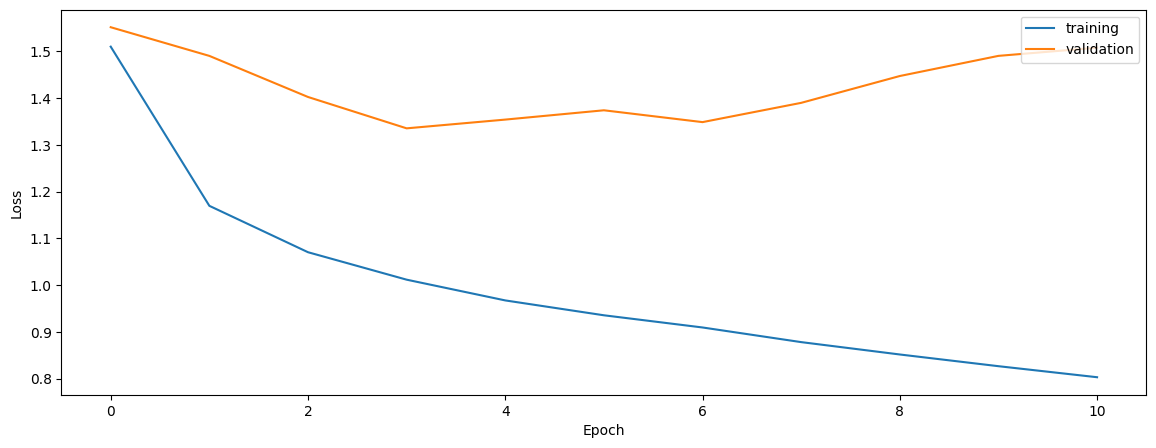

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6229484006813748
0.5028021207388765
0.5552619350811043


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5771826772974554
0.49469875366147836
0.5508074362459398


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5759602971010848
0.49159783537453716
0.5577582920320244


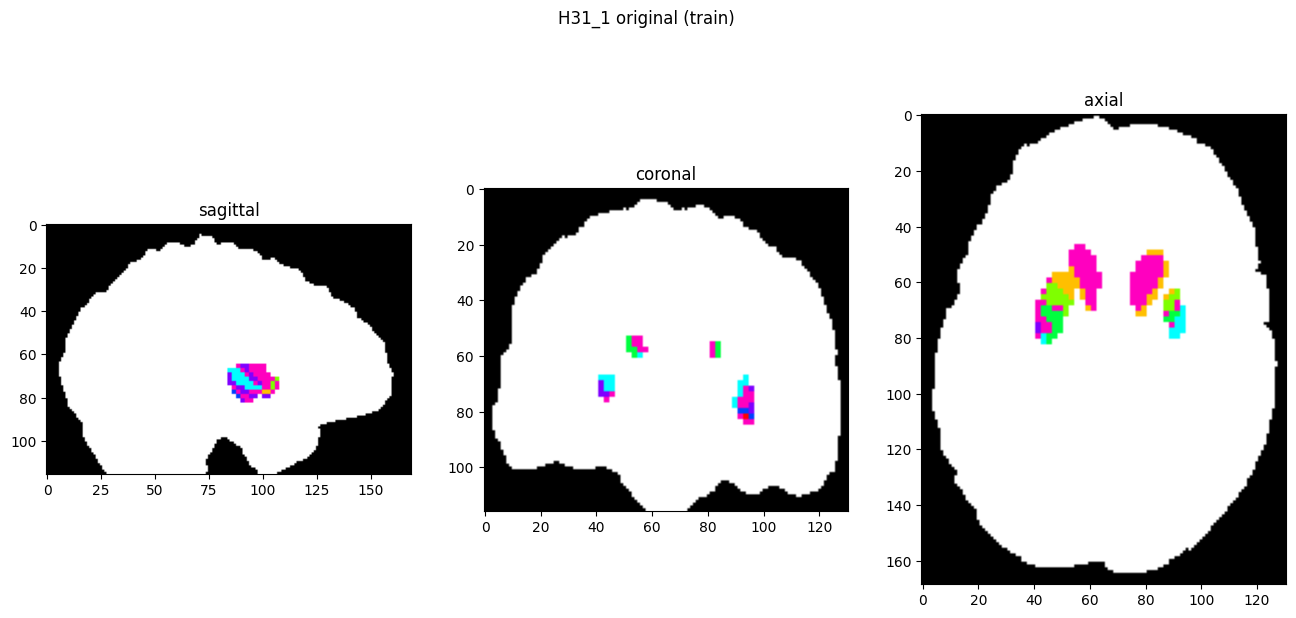

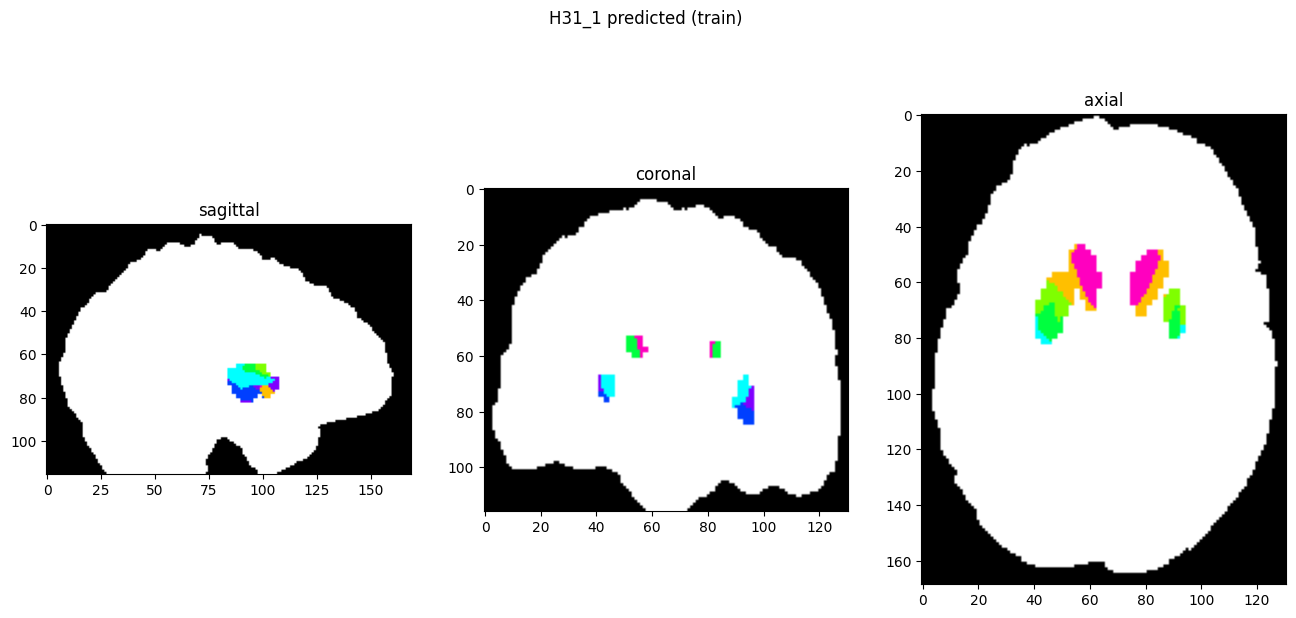

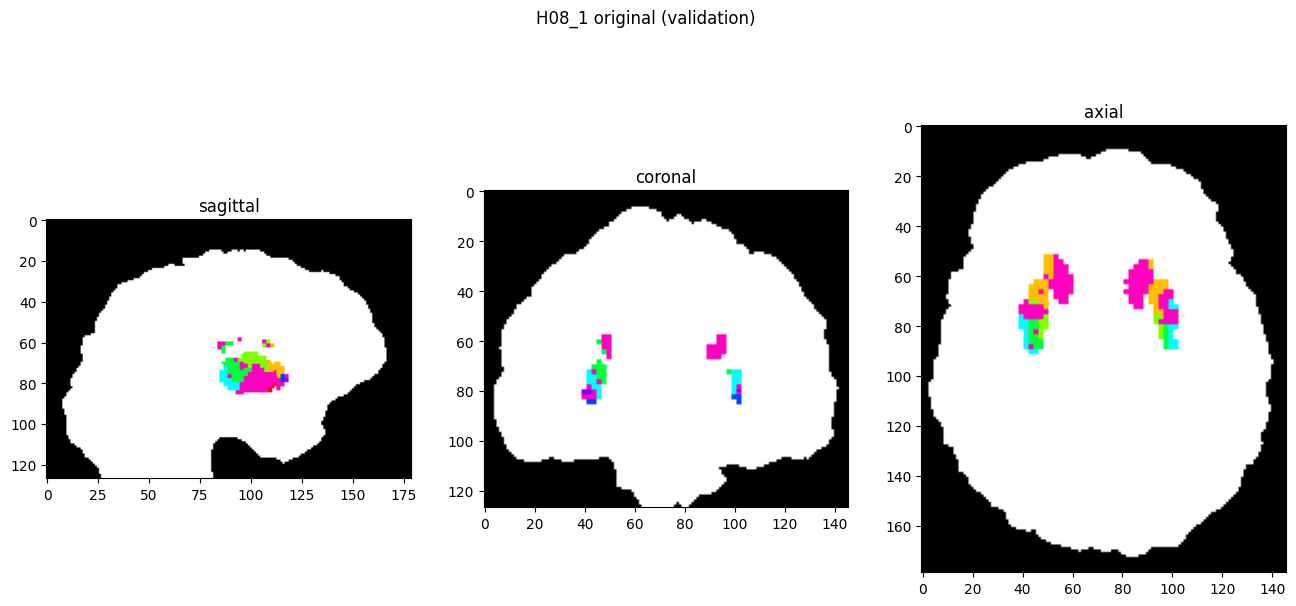

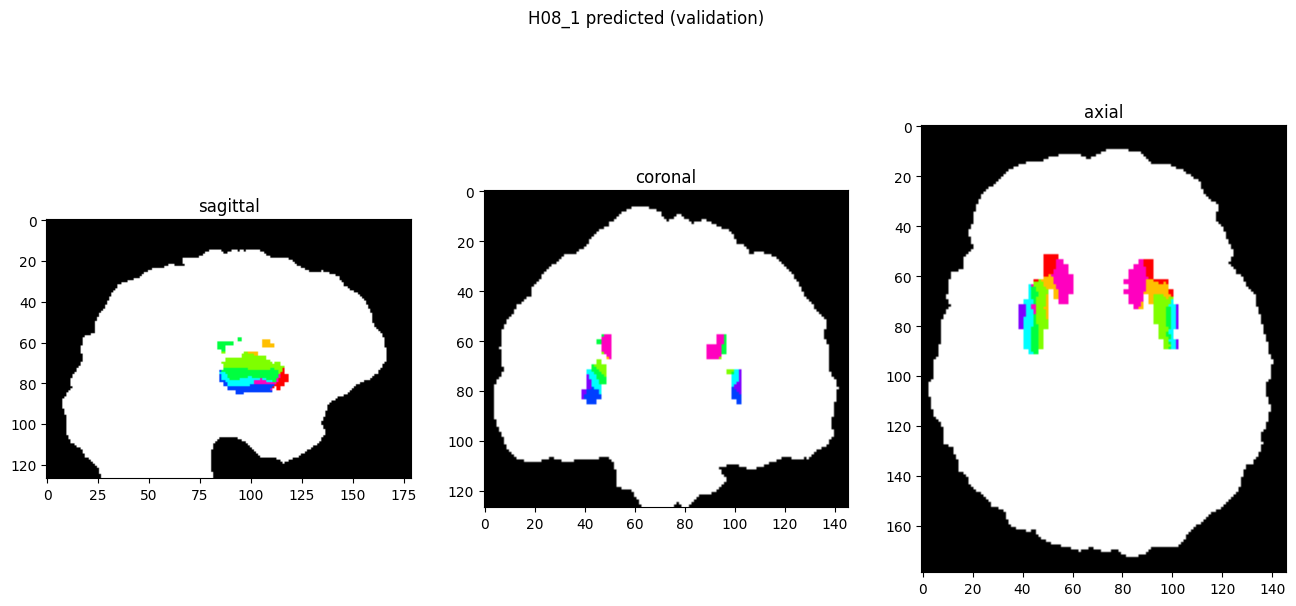

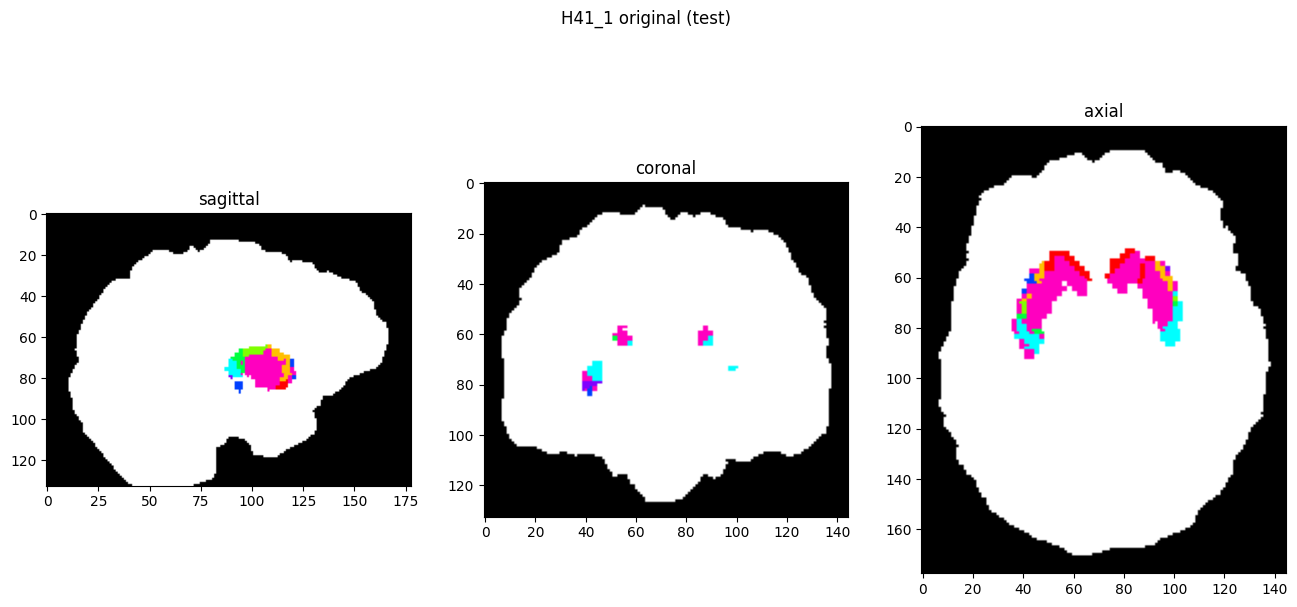

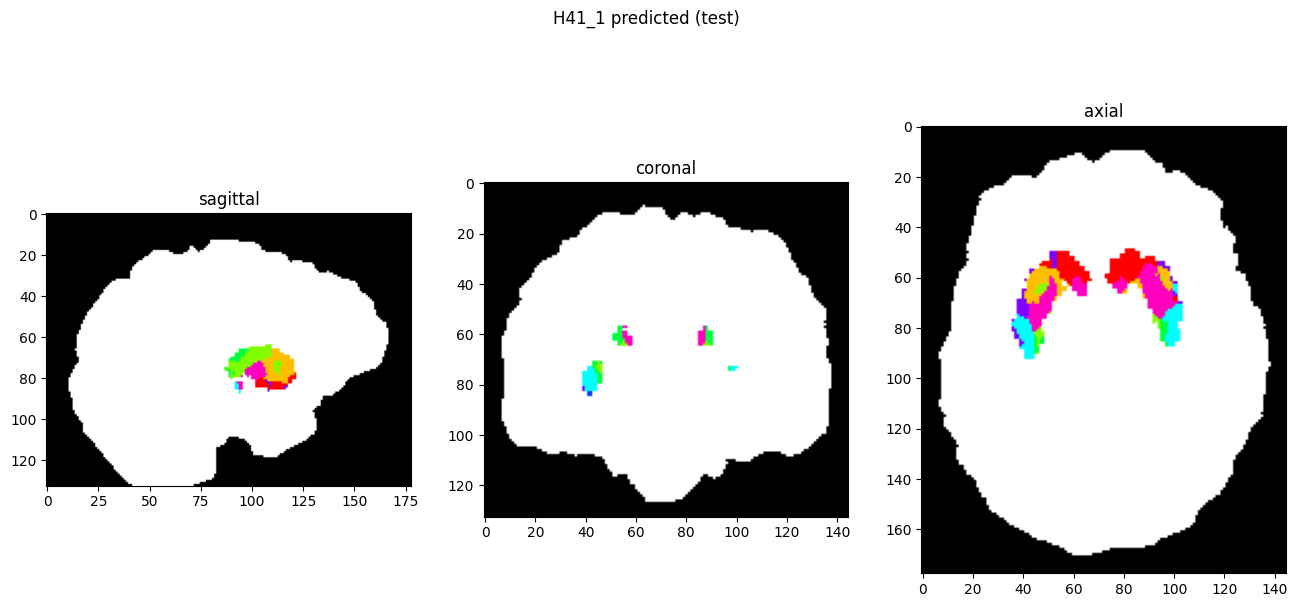

In [10]:
showResults(model, gen, threshold=0)